<a href="https://colab.research.google.com/github/mberkay0/woundHealingAnalysis/blob/master/WoundHealing(Scratch_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> # **Scratch Analysis**

<figure>
<img src="https://www.essenbioscience.com/media/cache/c8/5f/c85f2e44de0a2e0831412520c5ce635a.jpg"   width="300" height="200"/>
<center><figcaption>Wound Healing Analysis Notebook by Berkay Mayalı ®</figcaption></center>
</figure>


## Open In Colab 



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]()



> **Problem definition**




Cell migration plays an important role in development, physiology, and disease, and is often evaluated in 2D in vitro with a single layer wound healing test. Assay analysis, however, is a time-consuming task that is often performed manually. In order to speed up this analysis, an automatic analysis algorithm has been created in this workbook. This workbook helps to significantly reduce the time required for analysis and provides objective and reproducible quantification of tests. This workbook also allows easy review of analysis results.
<figure>
<img src="https://dlg7f0e93aole.cloudfront.net/wp-content/uploads/Figure-11.gif"   width="490" height="200"/>
<figcaption></figcaption>
</figure>


# **Importing Modules**

In [ ]:
import cv2
import time
import os
import glob 
import re
import json
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import seaborn as sns
from matplotlib import animation, rc
import matplotlib
!pip install celluloid
from celluloid import Camera
from plotly.subplots import make_subplots
import plotly.io as pio
import datetime



> And define some useful function 



In [ ]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

# **Clone the Data Set**

In [ ]:
!git clone https://github.com/mberkay0/woundHealingDataset.git

In [ ]:
path='/content/woundHealingDataset/data_set/'
path_ids = next(os.walk(path))[1]
path_ids.sort(key=natural_keys)
frames = []
masks = []

In [ ]:
for id in train_ids:
    for frame, mask in zip(next(os.walk(path + id + '/image/'))[-1], next(os.walk(path + id + '/mask/'))[-1]):
        frames.append(path+id+'/image/'+frame)
        masks.append(path+id+'/mask/'+mask)

# **Extracting and Saving Video Frames**




<figure>
<img src="https://www.mediacollege.com/video/frame-rate/img/frame-rates.jpg"   width="300" height="200"/>
</figure>


> ![alternatif metin](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcThv-aweNc5jZXHGJZOIZDpI6sK0CqMgX9-_Q&usqp=CAU)     

---

In [ ]:
def video_to_frames(input_loc, output_loc, file_type):
    """Bu fonksiyon belirtilen cikis noktasina yine
    belirtilen video girisi ile videonun karelerine ayrilmasini
    saglar ve cikan kareleri belirtilen formatta kaydeder.
    Args:
        input_loc (str): Videonun konumu.
        output_loc (str): Karelerin kaydedilecegi konum.
        file_type (str): Karelerin dosya tipi.
    Returns:
        None
    """
    file_type =  "/%#05d" + file_type

    try:
        if not os.path.exists(output_loc):
            os.makedirs(output_loc)
    except OSError:
        print ('Hata: Dosya olusturulamadi!')
    
    time_start = time.time()

    cap = cv2.VideoCapture(input_loc)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Kare sayisi: ", video_length)
    count = 0
    print ("Video karelerine ayriliyor..\n")
    
    while cap.isOpened():
        ret, frame = cap.read()
        cv2.imwrite(output_loc + file_type % (count+1), frame)
        count = count + 1
        if (count > (video_length-1)):
            time_end = time.time()
            cap.release()
            print ("Karelerine ayirma islemi tamamlandi.\n%d kare cikarildi." % count)
            print ("Bu islem %d saniye surdu." % (time_end-time_start))
            break

if __name__=="__main__":

    input_loc = '/content/MCF7_LacZ_48hrs_1.avi'
    output_loc = '/content/frames_png/'
    file_type = '.png'
    video_to_frames(input_loc, output_loc, file_type)

Kare sayisi:  47
Video karelerine ayriliyor..

Karelerine ayirma islemi tamamlandi.
47 kare cikarildi.
Bu islem 8 saniye surdu.


# **Simple Automatic Analysis Tool**



> **Final Algorithm**



In [ ]:
def saveImage(img, output_loc, name):
    """Bu fonksiyon belirtilen cikis noktasina gönderilen
    goruntuleri kayit eder.
    Args:
        img (numpy.array): Kaydedilecek karenin icerigi.
        output_loc (str): Karenin kaydedilecegi konum.
        name (str): Dosya adi degiskeni.
    Returns:
        None
    """   

    try:
        if not os.path.exists(output_loc):
            os.makedirs(output_loc)
    except OSError:
        print ('Hata: Dosya olusturulamadi!')

    try:
        print ('Goruntu kaydediliyor... ' + name)    
        cv2.imwrite(output_loc + name, img)
    except OSError:
        print ('Hata: Lokasyon dizgisini kontrol ediniz.\nDosya konumu ya da uzantisi hatali!')
    

In [ ]:
def makeVideo(img_loc, video_name='project', video_type='.avi', FPS=7):
    """Bu fonksiyon belirtilen cikis noktasina gönderilen
    resimleri kayit eder.
    Args:
        img_loc (list): Karelerin bulundugu konum bilgilerini tasiyan liste.
        video_name (str): Videonun kaydedilecegi isim bilgisi (default=project).
        video_type (str): Videonun uzantısını belirler (default=.avi).
        FPS (int): Saniyede kare sayisi (default=7).
    Returns:
        None
    """ 
    try:   
        img_array = []
        for filename in img_loc:
            img = cv2.imread(filename)
            height, width, layers = img.shape
            size = (width,height)
            img_array.append(img)
         
        out = cv2.VideoWriter('/content/' + video_name + video_type, cv2.VideoWriter_fourcc(*'DIVX'), FPS, size)
        
        for i in range(len(img_array)):
            out.write(img_array[i])
        out.release()
        print('Videonuz kaydedildi cikis lokasyonuna bakiniz.')
    except:
        print ('Hata: video olusturulamadi!')

In [ ]:
def contrast_eht(img_gray, alpha):
    """
    Bu fonksiyon kontrast ayari icin bir numpy.array seklinde
    bir restorasyon matrisi dondurur.
    Source:
        C. Lee, C. Lee, and Chang-Su Kim, "Contrast enahancement based on
        layered difference representation of 2D histograms," IEEE Trans. Image
        Image Process., vol. 22, no. 12, pp. 5372-5384, Dec. 2013
    Args:
        img_gray (numpy.array): Gri skalada goruntu.
        alpha (int): Artis seviyesi kaytsayisi.
    Returns:
        transfer_func (numpy.array): Gerekli contrast donusum matrixi.
    """
    U = np.zeros((255, 255))
    temp = np.arange(1, 256, 1, dtype=int)
    for layer in range(1, 256):
        U[:, layer - 1] = np.minimum(temp, 256 - layer) - np.maximum(temp - layer, 0)

    H, W = img_gray.shape
    hist2D = np.zeros((256, 256)) # 2d histogram optimization problem
    for j in range(1, H + 1):
        for i in range(1, H + 1):
            y = img_gray[j - 1, i - 1]
            if j != H:
                x = img_gray[j, i - 1]
            if i != W:
                x = img_gray[j - 1, i]
            hist2D[np.maximum(x, y), np.minimum(x, y)] = hist2D[np.maximum(x, y), np.minimum(x, y)] + 1
    del x, y
    temp2D = np.zeros((255, 255))
    temp1D = np.zeros((255, 1))

    for layer in range(1, 255):
        hist_layer = np.zeros((256 - layer, 1))
        loc = 1
        for j in range(1 + layer, 257):
            i = j - layer
            hist_layer[loc - 1, 0] = np.log(hist2D[j - 1, i - 1] + 1)
            loc += 1
        del loc
        temp1D[layer - 1, 0] = np.sum(hist_layer)

        if temp1D[layer - 1, 0] == 0:
            continue
        
        conv = np.convolve(np.squeeze(hist_layer), np.ones((layer,))) #convolution
        deconv = (conv - np.amin(conv)) / U[:, layer - 1]

        if np.sum(deconv) == 0:
            continue
        
        temp2D[:, layer - 1] = deconv / sum(deconv) #normalization

    lvl = (temp1D / np.amax(temp1D))**alpha
    hd = np.matmul(temp2D, lvl)
    hd /= np.sum(hd)
    tmp = np.zeros((256, 1))
    for i in range(1, 255):
        tmp[i] = tmp[i - 1] + hd[i - 1]
        transfer_func = (255 * tmp).astype(np.uint8)
    
    return transfer_func

In [ ]:
def get_mask(img, kernel_open = np.ones((2,2), np.uint8), kernel_close = np.ones((3,3), np.uint8), blockSize=25, C=5):
    """Bu fonksiyon gri skalada verilmis bir goruntuyu segmente
    edip ikili bir numpy.array seklinde bir maske olusturup dondurur
    Default tanimlanmis parametrelerin degiskenligi ile segmentasyonun 
    optimizasyonu saglanabilir.
    Args:
        img (numpy.array): Gri skalada goruntu.
        kernel_open (numpy.array): Morphological Open icin kullanilacak kernel.(Ex: (3, 3))
        kernel_close (numpy.array): Morphological Close icin kullanilacak kernel.(Ex: (3, 3))
        blockSize (int):Eşik değerini hesaplamak icin kullanılan 
        pixelneighborhood boyutunu temsil eden tam sayı turunde bir degisken.
        C (int): Sabiti temsil eden cift tip bir degisken
        adaptiveThreshold icin kullanilir.
        (Detayli bilgi icin opencv dokumantasyonuna bakiniz.) 
    Returns:
        mask (numpy.array): Segmente edilmis binary numpy.array. 
    """
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY)
    laplacian_img = cv2.Laplacian(thresh, cv2.CV_8UC1, ksize=kernel_close.shape[0])
    gaussian_blur = cv2.GaussianBlur(laplacian_img, (1,1), 0)     
    img_gau = cv2.adaptiveThreshold(gaussian_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C)  
    img_gau = (255 - img_gau)  

    img_open = cv2.morphologyEx(img_gau, cv2.MORPH_OPEN, kernel_open, iterations = 2) 
    img_close = cv2.morphologyEx(img_open, cv2.MORPH_CLOSE, kernel_close, iterations = 9)
    
    h, w = img_close.shape[:2]
    img_fill = img_close.copy()  
    for hi in range(h): # optimization problem
        cv2.floodFill(img_fill, None, (w//2, hi), 255) 
                
    img_fill = cv2.bitwise_not(img_fill) 
    img_fill_neg = cv2.bitwise_not((img_close | img_fill).copy())
    img_fill = img_fill_neg.copy()
            
    for hi in range(w): # optimization problem
        cv2.floodFill(img_fill, None, (hi,0), 255)

    img_fill = cv2.bitwise_not(img_fill)
    mask = cv2.bitwise_not((img_fill | img_fill_neg).copy())

    return mask

In [ ]:
def preprocessing(img, ldr=False, alpha = 28, clipLimit=1.6, tileGridSize=(32,32)):
    """Bu fonksiyon gri skalada verilmis bir goruntuyu 
    bazi onisleme algoritmalari ile isledikten sonra geri dondurur.
    Args:
        img (numpy.array): Gri skalada goruntu.
        ldr (bool): Kontrast düzeltme yapilip yapilmayacaginin secilmesi.
        Eger ldr = True ise farklı bir contrast enhancement yapilacaktir.
        alpha (int): Contrast enhancement icin seviye parametresi.
        clipLimit (float): Kontrast sinirlama esigi.
        tileGridSize (tuple): Histogram esitlemesi icin izgara boyutu. 
        Giris resmi, esit boyutta dikdortgen ızgaralara bolunecektir. 
    Returns:
        prep_img (numpy.array): On isleme sonucu goruntu (dtype=uint8). 
    """
    if ldr:
        contrast = contrast_eht(img,alpha)
        prep_img = contrast[img]
        prep_img = np.array(prep_img, dtype=np.uint8)
    else:
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        prep_img = clahe.apply(img)
    
    
    return prep_img

In [ ]:
def get_label(mask, img_org, name, size=3 ,cnt_side=-1, area=True, square=True):
    """Bu fonksiyon hucre sinirlarini isaretler
    ve orjinal goruntude cizilmis olarak geri dondurur.
    Args:
        mask (numpy.array): Binary maske goruntusu.
        img_org (numpy.array): Girdi olarak verilen orjinal goruntu.
        size (int): İsaretlemenin boyutu icin parametre.
        cnt_side (int): -1, 0, 1 seklinde bulunan konturlerin
        area (boolean): True, yara alaninin sinirlarini cizer
        False, hücresel alanin sinirini cizer.
        square (boolean): True, cizilen konturleri bir kutu icerisine alir.
        ne kadaranin cizileceginin parametresi. 
    Returns:
        img_org (numpy.array): Hucre sinirlari isaretlenmis goruntu. 
    """
    now = datetime.datetime.now()
    woundArea = (mask == 0).sum()
    
    if area:
        mask = cv2.bitwise_not(mask)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_org, contours, cnt_side, (0, 255, 0), size)
    cv2.putText(img_org, 'File: {}'.format(name), (2, 32), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(img_org, 'File: {}'.format(name), (0, 30), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img_org, 'Wound Area: {}pixels'.format(woundArea), (2, 62), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(img_org, 'Wound Area: {}pixels'.format(woundArea), (0, 60), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img_org, 'Date: {}/{}/{}'.format(now.day, now.month, now.year), (2, 92), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(img_org, 'Date: {}/{}/{}'.format(now.day, now.month, now.year), (0, 90), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2, cv2.LINE_AA)
    
    if square:
        for c in contours:
            rect = cv2.minAreaRect(c)
            boxPts = cv2.boxPoints(rect)
            boxPts = np.int0(boxPts)
            cv2.drawContours(img_org, [boxPts], 0, (0, 0, 255), size)
    
    return img_org

In [ ]:
def save_mask_label(path, save_mask=True, save_label=True, masks_loc="/content/masks/", labels_loc="/content/labels/"):
    """Maske ve isaretlemeleri belirtilen klasorlere kaydeder.
    Args:
        path (str): Goruntulerin bulundugu konum.
        save_mask (boolean): Maskelerin kayit secenegi icin bulunan parametre.
        save_label (boolean): İsaretlemelerin kayit secenegi icin bulunan parametre.
        masks_loc (str): Maskelerin kayit edilecegi konum.
        labels_loc (str): İsaretlemelerin kayit edilecegi konum.
    Returns:
        None 
    """
    if save_mask or save_label:
        for frame in path:
            name = frame.split("/")[-1]
            img = cv2.imread(frame)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            prep_img = preprocessing(img_gray)
            mask = get_mask(prep_img, ldr=True)
            saveImage(mask, "/content/masks/", name)
            if save_label:
                label = get_label(mask, img, name)
                saveImage(label, "/content/labels/", name)
    else:
        print("Hata!: maske ya da isaretleme kaydetmiyorsunuz.")



> ****



In [ ]:
if __name__=="__main__":
    path = glob.glob('/content/frames/*.png')
    path.sort(key=natural_keys)
    save_mask_label(path)

Goruntu kaydediliyor... 00001.png
Goruntu kaydediliyor... 00001.png
Goruntu kaydediliyor... 00004.png
Goruntu kaydediliyor... 00004.png
Goruntu kaydediliyor... 00007.png
Goruntu kaydediliyor... 00007.png
Goruntu kaydediliyor... 00010.png
Goruntu kaydediliyor... 00010.png
Goruntu kaydediliyor... 00013.png
Goruntu kaydediliyor... 00013.png
Goruntu kaydediliyor... 00016.png
Goruntu kaydediliyor... 00016.png
Goruntu kaydediliyor... 00019.png
Goruntu kaydediliyor... 00019.png
Goruntu kaydediliyor... 00022.png
Goruntu kaydediliyor... 00022.png
Goruntu kaydediliyor... 00025.png
Goruntu kaydediliyor... 00025.png
Goruntu kaydediliyor... 00028.png
Goruntu kaydediliyor... 00028.png
Goruntu kaydediliyor... 00031.png
Goruntu kaydediliyor... 00031.png
Goruntu kaydediliyor... 00034.png
Goruntu kaydediliyor... 00034.png
Goruntu kaydediliyor... 00037.png
Goruntu kaydediliyor... 00037.png


In [ ]:
labels = glob.glob('/content/labels/*.png')
labels.sort(key=natural_keys)
print(labels)

['/content/labels/00001.png', '/content/labels/00004.png', '/content/labels/00007.png', '/content/labels/00010.png', '/content/labels/00013.png', '/content/labels/00016.png', '/content/labels/00019.png', '/content/labels/00022.png', '/content/labels/00025.png', '/content/labels/00028.png', '/content/labels/00031.png', '/content/labels/00034.png', '/content/labels/00037.png']


In [ ]:
makeVideo(labels)

Videonuz kaydedildi cikis lokasyonuna bakiniz.


# **Manually Labelled Images**



> **We used supervisly labelling tool and supervisely json-based annotation format supports:**


```
{
    "description": "",
    "tags": [],
    "bitmap": null,
    "classTitle": "basil",
    "points": {
        "exterior": [
            [
                834,
                848
            ],
            [
                941,
                791
            ]
        ],
        "interior": []
    }
}
```
> **Fields explanation:**

> "description" (optional) - string - the text description of object

> "tags" - list of strings - object tags

> "bitmap" always equals to null

> "classTitle" - string - the title of a class. It is used to identify the class shape from file meta.json

> "points" - object with two fields:

> "exterior" - list of points (x and y coordinates), e.g. [[x1, y1], [x2, y2], [x3, y3], [x4, y4], ...]

> "interior" - always an empty list for this shape


In [ ]:
hand_data_path = glob.glob('/content/labelling_data/*.json')
hand_data_path.sort(key=natural_keys)
print(hand_data_path)

['/content/labelling_data/00001.png.json', '/content/labelling_data/00004.png.json', '/content/labelling_data/00007.png.json', '/content/labelling_data/00010.png.json', '/content/labelling_data/00013.png.json', '/content/labelling_data/00016.png.json', '/content/labelling_data/00019.png.json', '/content/labelling_data/00022.png.json', '/content/labelling_data/00025.png.json', '/content/labelling_data/00028.png.json', '/content/labelling_data/00031.png.json', '/content/labelling_data/00034.png.json', '/content/labelling_data/00037.png.json']




> **Manually Labelled Images Extracting**



In [ ]:
path = glob.glob('/content/frames_png/*.png')
path.sort(key=natural_keys)
print(path)

['/content/frames_png/00001.png', '/content/frames_png/00002.png', '/content/frames_png/00003.png', '/content/frames_png/00004.png', '/content/frames_png/00005.png', '/content/frames_png/00006.png', '/content/frames_png/00007.png', '/content/frames_png/00008.png', '/content/frames_png/00009.png', '/content/frames_png/00010.png', '/content/frames_png/00011.png', '/content/frames_png/00012.png', '/content/frames_png/00013.png', '/content/frames_png/00014.png', '/content/frames_png/00015.png', '/content/frames_png/00016.png', '/content/frames_png/00017.png', '/content/frames_png/00018.png', '/content/frames_png/00019.png', '/content/frames_png/00020.png', '/content/frames_png/00021.png', '/content/frames_png/00022.png', '/content/frames_png/00023.png', '/content/frames_png/00024.png', '/content/frames_png/00025.png', '/content/frames_png/00026.png', '/content/frames_png/00027.png', '/content/frames_png/00028.png', '/content/frames_png/00029.png', '/content/frames_png/00030.png', '/content

In [ ]:
l_path = []
for i in path:
    for j in hand_data_path:
        if i.split("/")[-1] in j.split("/")[-1]:
            l_path.append(i)

l_path

['/content/frames_png/00001.png',
 '/content/frames_png/00004.png',
 '/content/frames_png/00007.png',
 '/content/frames_png/00010.png',
 '/content/frames_png/00013.png',
 '/content/frames_png/00016.png',
 '/content/frames_png/00019.png',
 '/content/frames_png/00022.png',
 '/content/frames_png/00025.png',
 '/content/frames_png/00028.png',
 '/content/frames_png/00031.png',
 '/content/frames_png/00034.png',
 '/content/frames_png/00037.png']

In [ ]:
for hand, l in zip(hand_data_path, l_path):
    with open(hand) as f:
        data = json.load(f)
    f.close()
    
    img = cv2.imread(l)
    task = np.zeros(img.shape[:2])
    
    for i in data['objects']:
      arr = np.array(i['points']['exterior'], dtype=np.int32)
      cv2.fillPoly(task, pts =[arr], color=(255,255,255))
      cv2.polylines(img, [arr], True, (0,255,0), 3)

    name_mask = "hand_mask" + str(l.split("/")[-1])
    name_label = "hand_label" + str(l.split("/")[-1])

    saveImage(task, '/content/hand_mask/', name_mask)#masks
    saveImage(img, '/content/labell/', name_label)#contoured images




Resim kaydediliyor.../content/hand_mask/outhand_mask00001.png.png
Resim kaydediliyor.../content/labell/outhand_label00001.png.png
Resim kaydediliyor.../content/hand_mask/outhand_mask00004.png.png
Resim kaydediliyor.../content/labell/outhand_label00004.png.png
Resim kaydediliyor.../content/hand_mask/outhand_mask00007.png.png
Resim kaydediliyor.../content/labell/outhand_label00007.png.png
Resim kaydediliyor.../content/hand_mask/outhand_mask00010.png.png
Resim kaydediliyor.../content/labell/outhand_label00010.png.png
Resim kaydediliyor.../content/hand_mask/outhand_mask00013.png.png
Resim kaydediliyor.../content/labell/outhand_label00013.png.png
Resim kaydediliyor.../content/hand_mask/outhand_mask00016.png.png
Resim kaydediliyor.../content/labell/outhand_label00016.png.png
Resim kaydediliyor.../content/hand_mask/outhand_mask00019.png.png
Resim kaydediliyor.../content/labell/outhand_label00019.png.png
Resim kaydediliyor.../content/hand_mask/outhand_mask00022.png.png
Resim kaydediliyor.../co

# **Similarity Coefficient**



> **Dice Coefficient**

Sørensen's original formula was intended to be applied to discrete data. Given two sets, X and Y, it is defined as

![alternatif metin](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)
where |X| and |Y| are the cardinalities of the two sets (i.e. the number of elements in each set). The Sørensen index equals twice the number of elements common to both sets divided by the sum of the number of elements in each set.

When applied to Boolean data, using the definition of true positive (TP), false positive (FP), and false negative (FN), it can be written as

![alternatif metin](https://wikimedia.org/api/rest_v1/media/math/render/svg/174f40f295f784c6fc6f78d359503821b757a353)


[**Source**](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)

In [ ]:
def dice_coefficient(im1, im2):
    """
    İki set arasındaki benzerliğin bir ölçüsü 
    olan zar katsayısını hesaplar.
    
    Parameters
    ----------
    im1 : array-like, bool
         Herhangi bir boyutta dizi. Boolean değilse dönüştürülür.
    im2 : array-like, bool
        im1 ile aynı boyuta sahip olmalı. Boolean değilse dönüştürülür.
    -------
    dice : float
        Zar katsayısı [0,1] arasında giden float bir değer döndürür.
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    İki dizi içinde fonsiyona girdi sırası önemsizdir sonuç yine aynı çıkacaktır.
    """
    smooth = 1.

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Şekil uyuşmuyor: im1 ve im2 aynı boyuta sahip olmalı (Ör:(345, 200) ve (345, 200)).")

    intersection = np.logical_and(im1, im2)

    return (smooth + (2. * intersection.sum())) / (im1.sum() + im2.sum() + smooth)


In [ ]:
algorithm = glob.glob('/content/algorithm_out/*.png')
algorithm.sort(key=natural_keys)
print(algorithm)

['/content/algorithm_out/out1.png', '/content/algorithm_out/out2.png', '/content/algorithm_out/out3.png', '/content/algorithm_out/out4.png', '/content/algorithm_out/out5.png', '/content/algorithm_out/out6.png', '/content/algorithm_out/out7.png', '/content/algorithm_out/out8.png', '/content/algorithm_out/out9.png', '/content/algorithm_out/out10.png', '/content/algorithm_out/out11.png', '/content/algorithm_out/out12.png', '/content/algorithm_out/out13.png']


In [ ]:
hand_out = glob.glob('/content/hand_out/*.png')
hand_out.sort(key=natural_keys)
print(hand_out)

['/content/hand_out/out1.png', '/content/hand_out/out2.png', '/content/hand_out/out3.png', '/content/hand_out/out4.png', '/content/hand_out/out5.png', '/content/hand_out/out6.png', '/content/hand_out/out7.png', '/content/hand_out/out8.png', '/content/hand_out/out9.png', '/content/hand_out/out10.png', '/content/hand_out/out11.png', '/content/hand_out/out12.png', '/content/hand_out/out13.png']




> **Old Algorithm**



In [ ]:
sum = 0

for frame, hand in zip(l_path, hand_mask):
    img1 = cv2.imread(frame, 0)
    img2 = cv2.imread(hand, 0)

    im1 = img1 == 0
    im2 = img2 == 0

    sum += dice_coefficient(img1, img2)
    print('Dice coefficient: ' + '(' + frame.split("/")[-1] + ") için -> " + str(dice_coefficient(im1, im2)))
  
print('\n\n\n Dice coefficient mean -> ', sum/len(l_path))

Dice coefficient: (00001.png) için -> 0.9521715414117239
Dice coefficient: (00004.png) için -> 0.9703539242086959
Dice coefficient: (00007.png) için -> 0.9523040113469897
Dice coefficient: (00010.png) için -> 0.9511489172100654
Dice coefficient: (00013.png) için -> 0.9327907593566532
Dice coefficient: (00016.png) için -> 0.9069156315277535
Dice coefficient: (00019.png) için -> 0.8700859470702201
Dice coefficient: (00022.png) için -> 0.8034321471064079
Dice coefficient: (00025.png) için -> 0.7476403007742981
Dice coefficient: (00028.png) için -> 0.6009889834752128
Dice coefficient: (00031.png) için -> 0.43762477604299976
Dice coefficient: (00034.png) için -> 0.6637314798783052
Dice coefficient: (00037.png) için -> 1.0



 Dice coefficient mean ->  0.9885573492607277




> **Algorithm vs Ground Truth Coefficient with CHLAE Reference to the Wound Area**



In [ ]:
gnd_truth = glob.glob('/content/ground_truth/*.png')
gnd_truth.sort(key=natural_keys)
print(gnd_truth)

In [ ]:
masks = glob.glob('/content/masks/*.png')
masks.sort(key=natural_keys)
print(masks)

['/content/masks/00001.png', '/content/masks/00004.png', '/content/masks/00007.png', '/content/masks/00010.png', '/content/masks/00013.png', '/content/masks/00016.png', '/content/masks/00019.png', '/content/masks/00022.png', '/content/masks/00025.png', '/content/masks/00028.png', '/content/masks/00031.png', '/content/masks/00034.png', '/content/masks/00037.png']


In [ ]:
CLAHE = []
for mask, gnd in zip(masks, gnd_truth):
    img1 = cv2.imread(mask, 0)
    img2 = cv2.imread(gnd, 0)

    im1 = img1 == 0
    im2 = img2 == 0
    
    CLAHE.append(dice_coefficient(im1, im2))
    print('Dice coefficient: ' + '(' + mask.split("/")[-1] + ") için -> " + str(dice_coefficient(im1, im2)))

Dice coeff -> 00001.png 0.9898594372402285
Dice coeff -> 00004.png 0.9898279263555749
Dice coeff -> 00007.png 0.9811096716263873
Dice coeff -> 00010.png 0.9743267844198125
Dice coeff -> 00013.png 0.9626530912007386
Dice coeff -> 00016.png 0.9507950616378942
Dice coeff -> 00019.png 0.9237075499806056
Dice coeff -> 00022.png 0.9062435682366043
Dice coeff -> 00025.png 0.8144954345088161
Dice coeff -> 00028.png 0.8203632152137734
Dice coeff -> 00031.png 0.6971321613664795
Dice coeff -> 00034.png 0.7355153663070482
Dice coeff -> 00037.png 5.890322200624374e-05




> **Algorithm vs Ground Truth with Contrast Enhancement Coefficient Reference to the Wound Area**



In [ ]:
sum = 0

for mask, gnd in zip(masks, gnd_truth):
    img1 = cv2.imread(mask, 0)
    img2 = cv2.imread(gnd, 0)

    im1 = img1 == 0
    im2 = img2 == 0

    sum += dice_coefficient(img1, img2)
    print('Dice coefficient: ' + '(' + mask.split("/")[-1] + ") için -> " + str(dice_coefficient(im1, im2)))

print('\n\n\n Dice coefficient mean -> ', sum/len(masks))

Dice coefficient: (00001.png) için -> 0.9835378015442634
Dice coefficient: (00004.png) için -> 0.9865824484539626
Dice coefficient: (00007.png) için -> 0.974710816667391
Dice coefficient: (00010.png) için -> 0.9693859419911157
Dice coefficient: (00013.png) için -> 0.9578544061302682
Dice coefficient: (00016.png) için -> 0.940524702948035
Dice coefficient: (00019.png) için -> 0.9105296480037798
Dice coefficient: (00022.png) için -> 0.8724955262872724
Dice coefficient: (00025.png) için -> 0.7922815532023815
Dice coefficient: (00028.png) için -> 0.7736622731817107
Dice coefficient: (00031.png) için -> 0.5656381556138874
Dice coefficient: (00034.png) için -> 0.7016710611325498
Dice coefficient: (00037.png) için -> 0.0



 Dice coefficient mean ->  0.9924874812679813




> **Algorithm vs Ground Truth with Contrast Enhancement Coefficient Reference to the Cell Area**



In [ ]:
sum = 0
LDR = []
for mask, gnd in zip(masks, gnd_truth):
    img1 = cv2.imread(mask, 0)
    img2 = cv2.imread(gnd, 0)

    im1 = img1 == 255
    im2 = img2 == 255

    LDR.append(dice_coefficient(im1, im2))
    sum += dice_coefficient(img1, img2)
    print('Dice coefficient: ' + '(' + mask.split("/")[-1] + ") için -> " + str(dice_coefficient(im1, im2)))
  
print('\n\n\n Dice coefficient mean -> ', sum/len(masks))

Dice coefficient: (00001.png) için -> 0.9910262389253058
Dice coefficient: (00004.png) için -> 0.9938102144411064
Dice coefficient: (00007.png) için -> 0.9910156327548898
Dice coefficient: (00010.png) için -> 0.9919780896953099
Dice coefficient: (00013.png) için -> 0.992288262014679
Dice coefficient: (00016.png) için -> 0.9921173433806637
Dice coefficient: (00019.png) için -> 0.9905326993935576
Dice coefficient: (00022.png) için -> 0.9916087800667712
Dice coefficient: (00025.png) için -> 0.9902431478519721
Dice coefficient: (00028.png) için -> 0.9911953873246119
Dice coefficient: (00031.png) için -> 0.991922293684704
Dice coefficient: (00034.png) için -> 0.9968779300813493
Dice coefficient: (00037.png) için -> 0.9977212368688358



 Dice coefficient mean ->  0.9924874812679813


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=frames,
    y=CLAHE,
    name='CLAHE',
    marker_color='skyblue'
))
fig.add_trace(go.Bar(
    x=frames,
    y=LDR,
    name='LDR',
    marker_color='green'
))

fig.update_layout(barmode='group', xaxis_tickangle=0)
fig.update_layout(
    title_text='CLAHE vs LDR (Contrast Enhancement)',
    showlegend=True,
    yaxis=dict(
        title="Dice Score",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Frames",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
    ))
fig.show()



> **Labelled Data Comparison of two Experts**



In [ ]:
path_1 = glob.glob('/content/masks/*.png')
path_1.sort(key=natural_keys)
print(path_1)

['/content/masks/frame_1.png', '/content/masks/frame_4.png', '/content/masks/frame_7.png', '/content/masks/frame_10.png', '/content/masks/frame_13.png', '/content/masks/frame_16.png', '/content/masks/frame_19.png', '/content/masks/frame_22.png', '/content/masks/frame_25.png', '/content/masks/frame_28.png', '/content/masks/frame_31.png', '/content/masks/frame_34.png', '/content/masks/frame_37.png']


In [ ]:
path_2 = glob.glob('/content/masks_2/*.png')
path_2.sort(key=natural_keys)
print(path_2)

['/content/masks_2/out1.png', '/content/masks_2/out4.png', '/content/masks_2/out7.png', '/content/masks_2/out10.png', '/content/masks_2/out13.png', '/content/masks_2/out16.png', '/content/masks_2/out19.png', '/content/masks_2/out22.png', '/content/masks_2/out25.png', '/content/masks_2/out28.png', '/content/masks_2/out31.png', '/content/masks_2/out34.png', '/content/masks_2/out37.png']




> **Dice Coefficent with Reference to the Wound Area**



In [ ]:
expert_dice = []
print('2 Kişinin Etiket Karşılaştırması...\n')
for frame1, frame2 in zip(path_1, path_2):
    img1 = cv2.imread(frame1, 0)
    img2 = cv2.imread(frame2, 0)
    
    im1 = img1 == 0
    im2 = img2 == 0

    expert_dice.append(dice_coefficient(im1, im2))    
    print('Dice coefficient: ' + '(' + frame1.split("/")[-1].split(".")[0] + ") için -> " + str(dice_coefficient(im1, im2)))



2 Kişinin Etiket Karşılaştırması...

Dice coefficient: (frame_1) için -> 0.9815954611575747
Dice coefficient: (frame_4) için -> 0.9775583121411229
Dice coefficient: (frame_7) için -> 0.9688922110679828
Dice coefficient: (frame_10) için -> 0.9575503987177273
Dice coefficient: (frame_13) için -> 0.9473202450450112
Dice coefficient: (frame_16) için -> 0.925575274477365
Dice coefficient: (frame_19) için -> 0.8590543410101471
Dice coefficient: (frame_22) için -> 0.7842275883893441
Dice coefficient: (frame_25) için -> 0.7299256755128527
Dice coefficient: (frame_28) için -> 0.716087659670152
Dice coefficient: (frame_31) için -> 0.4801600405477012
Dice coefficient: (frame_34) için -> 0.6106737139606159
Dice coefficient: (frame_37) için -> 1.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=frames,
    y=expert_dice,
))

fig.update_layout(
    title_text='Expert-1 vs Expert-2',
    showlegend=False,
    yaxis=dict(
        title="Dice Score",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Frames",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        tickvals = frames,
        ticks="outside",
        tickson="boundaries",
        ticklen=5
    ))
fig.show()



> **Dice Coefficient with Reference to the Cell Area**



In [ ]:
expert_dicecell = []
print('2 Kişinin Etiket Karşılaştırması...\n')
for frame1, frame2 in zip(path_1, path_2):
    img1 = cv2.imread(frame1, 0)
    img2 = cv2.imread(frame2, 0)
    
    im1 = img1 == 255
    im2 = img2 == 255
    
    expert_dicecell.append(dice_coefficient(im1, im2))
    print('Dice coefficient: ' + '(' + frame1.split("/")[-1].split(".")[0] + ") için -> " + str(dice_coefficient(im1, im2)))

2 Kişinin Etiket Karşılaştırması...

Dice coefficient: (frame_1) için -> 0.9897517588825363
Dice coefficient: (frame_4) için -> 0.9897126287932456
Dice coefficient: (frame_7) için -> 0.9890105614026071
Dice coefficient: (frame_10) için -> 0.989106338417542
Dice coefficient: (frame_13) için -> 0.9903882732999585
Dice coefficient: (frame_16) için -> 0.989827742788767
Dice coefficient: (frame_19) için -> 0.9840751023799489
Dice coefficient: (frame_22) için -> 0.9831144198221587
Dice coefficient: (frame_25) için -> 0.9850257266536606
Dice coefficient: (frame_28) için -> 0.987608014881631
Dice coefficient: (frame_31) için -> 0.9874630166213374
Dice coefficient: (frame_34) için -> 0.9961253767730456
Dice coefficient: (frame_37) için -> 1.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=frames,
    y=expert_dicecell,
))

fig.update_layout(
    title_text='Expert-1 vs Expert-2',
    showlegend=False,
    yaxis=dict(
        title="Dice Score",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Frames",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        tickvals = frames,
        ticks="outside",
        tickson="boundaries",
        ticklen=5
    ))
fig.show()



> **Dice Coeff with 2 Scratch Surface**



In [ ]:
print('2 Kişinin Etiket Karşılaştırması Yara Yüzeyleri...')
for frame1, frame2 in zip(path_1, path_2):
    img1 = cv2.imread(frame1, 0)
    img2 = cv2.imread(frame2, 0)
    
    img1 = np.array_split(img1, 2, axis=1)
    left_side1 = img1[0]
    right_side1 = img1[1]
    
    img2 = np.array_split(img2, 2, axis=1)
    left_side2 = img2[0]
    right_side2 = img2[1]

    im1 = left_side1 == 0
    im2 = left_side2 == 0

    im3 = right_side1 == 0
    im4 = right_side2 == 0

    print('\nSol Yara Yüzeyi - Dice coefficient: ' + '(' + frame1.split("/")[-1].split(".")[0] + ") için -> " + str(dice_coefficient(im1, im2)))
    print('\nSağ Yara Yüzeyi - Dice coefficient: ' + '(' + frame1.split("/")[-1].split(".")[0] + ") için -> " + str(dice_coefficient(im3, im4)))
    print('-'*100)

2 Kişinin Etiket Karşılaştırması Yara Yüzeyleri...

Sol Yara Yüzeyi - Dice coefficient: (frame_1) için -> 0.9748357619702281

Sağ Yara Yüzeyi - Dice coefficient: (frame_1) için -> 0.9864609872957626
------------------------------------------------------------------------------------------

Sol Yara Yüzeyi - Dice coefficient: (frame_4) için -> 0.9728699052156234

Sağ Yara Yüzeyi - Dice coefficient: (frame_4) için -> 0.9807567973550033
------------------------------------------------------------------------------------------

Sol Yara Yüzeyi - Dice coefficient: (frame_7) için -> 0.9682514786815424

Sağ Yara Yüzeyi - Dice coefficient: (frame_7) için -> 0.9693149387011685
------------------------------------------------------------------------------------------

Sol Yara Yüzeyi - Dice coefficient: (frame_10) için -> 0.9554483495862782

Sağ Yara Yüzeyi - Dice coefficient: (frame_10) için -> 0.958871983188211
-----------------------------------------------------------------------------------



> **PyScratch vs Algorithm**



In [ ]:
pyScratch = glob.glob('/content/pyscratch_mask/*.png')
pyScratch.sort(key=natural_keys)
print(pyScratch)

['/content/pyscratch_mask/00001mask.png', '/content/pyscratch_mask/00004mask.png', '/content/pyscratch_mask/00007mask.png', '/content/pyscratch_mask/00010mask.png', '/content/pyscratch_mask/00013mask.png', '/content/pyscratch_mask/00016mask.png', '/content/pyscratch_mask/00019mask.png', '/content/pyscratch_mask/00022mask.png', '/content/pyscratch_mask/00025mask.png', '/content/pyscratch_mask/00028mask.png', '/content/pyscratch_mask/00031mask.png', '/content/pyscratch_mask/00034mask.png', '/content/pyscratch_mask/00037mask.png']


In [ ]:
gnd_truth = glob.glob('/content/gnd_truth/*.png')
gnd_truth.sort(key=natural_keys)
print(gnd_truth)

['/content/gnd_truth/frame_1.png', '/content/gnd_truth/frame_4.png', '/content/gnd_truth/frame_7.png', '/content/gnd_truth/frame_10.png', '/content/gnd_truth/frame_13.png', '/content/gnd_truth/frame_16.png', '/content/gnd_truth/frame_19.png', '/content/gnd_truth/frame_22.png', '/content/gnd_truth/frame_25.png', '/content/gnd_truth/frame_28.png', '/content/gnd_truth/frame_31.png', '/content/gnd_truth/frame_34.png', '/content/gnd_truth/frame_37.png']


In [ ]:
algorithm = glob.glob('/content/algorithm/*.png')
algorithm.sort(key=natural_keys)
print(algorithm)

['/content/algorithm/00001.png', '/content/algorithm/00004.png', '/content/algorithm/00007.png', '/content/algorithm/00010.png', '/content/algorithm/00013.png', '/content/algorithm/00016.png', '/content/algorithm/00019.png', '/content/algorithm/00022.png', '/content/algorithm/00025.png', '/content/algorithm/00028.png', '/content/algorithm/00031.png', '/content/algorithm/00034.png', '/content/algorithm/00037.png']


In [ ]:
pysh_vs_gnd = []
print('pyScratch vs Ground Truth')
print('-'*50)
for f, f2 in zip(pyScratch, gnd_truth):
    img1 = cv2.imread(f, 0)
    img2 = cv2.imread(f2, 0)
    
    im1 = img1 == 255
    im2 = img2 == 0

    pysh_vs_gnd.append(dice_coefficient(im1, im2))    
    print('Dice coefficient: ' + '(' + f2.split("/")[-1].split(".")[0] + ") için -> " + str(dice_coefficient(im1, im2)))

pyScratch vs Ground Truth
--------------------------------------------------
Dice coefficient: (frame_1) için -> 0.989146191514786
Dice coefficient: (frame_4) için -> 0.9850055641109225
Dice coefficient: (frame_7) için -> 0.9625145157033518
Dice coefficient: (frame_10) için -> 0.9531329736371429
Dice coefficient: (frame_13) için -> 0.9151180316777926
Dice coefficient: (frame_16) için -> 0.908147944210126
Dice coefficient: (frame_19) için -> 0.8745196428662
Dice coefficient: (frame_22) için -> 0.6159229163030339
Dice coefficient: (frame_25) için -> 0.6682389023261637
Dice coefficient: (frame_28) için -> 0.48965433144646825
Dice coefficient: (frame_31) için -> 0.47360971600767054
Dice coefficient: (frame_34) için -> 0.554294640168624
Dice coefficient: (frame_37) için -> 0.00010442773600668337


In [ ]:
alg_vs_gnd = []
print('Algorithm vs Ground Truth')
print('-'*50)
for f, f2 in zip(algorithm, gnd_truth):
    img1 = cv2.imread(f, 0)
    img2 = cv2.imread(f2, 0)
    
    im1 = img1 == 0
    im2 = img2 == 0
    
    alg_vs_gnd.append(dice_coefficient(im1, im2))    
    print('Dice coefficient: ' + '(' + f2.split("/")[-1].split(".")[0] + ") için -> " + str(dice_coefficient(im1, im2)))

Algorithm vs Ground Truth
--------------------------------------------------
Dice coefficient: (frame_1) için -> 0.9835378099828074
Dice coefficient: (frame_4) için -> 0.9865824561403509
Dice coefficient: (frame_7) için -> 0.9747108341140548
Dice coefficient: (frame_10) için -> 0.9693859686560677
Dice coefficient: (frame_13) için -> 0.957854455406186
Dice coefficient: (frame_16) için -> 0.940524794857134
Dice coefficient: (frame_19) için -> 0.9105298170946051
Dice coefficient: (frame_22) için -> 0.8724958997188379
Dice coefficient: (frame_25) için -> 0.7922823904999153
Dice coefficient: (frame_28) için -> 0.7736633663366337
Dice coefficient: (frame_31) için -> 0.5656424581005587
Dice coefficient: (frame_34) için -> 0.7016762702985856
Dice coefficient: (frame_37) için -> 7.953551260637875e-05


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=frames,
    y=pysh_vs_gnd,
    name='pyScratch vs Ground Truth',
    marker_color='skyblue'
))
fig.add_trace(go.Bar(
    x=frames,
    y=alg_vs_gnd,
    name='Algorithm vs Ground Truth',
    marker_color='dimgray'
))

fig.update_layout(barmode='group', xaxis_tickangle=0)
fig.update_layout(
    title_text='pyScratch vs Ground Truth and Algorithm vs Ground Truth',
    showlegend=True,
    yaxis=dict(
        title="Dice Score",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Frames",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
    ))
fig.show()

In [ ]:
pysh_vs_alg = []
print('pyScratch vs Algorithm')
print('-'*50)
for f, f2 in zip(pyScratch, algorithm):
    img1 = cv2.imread(f, 0)
    img2 = cv2.imread(f2, 0)
    
    im1 = img1 == 255
    im2 = img2 == 0

    pysh_vs_alg.append(dice_coefficient(im1, im2))    
    print('Dice coefficient: ' + '(' + f2.split("/")[-1].split(".")[0] + ") için -> " + str(dice_coefficient(im1, im2)))

pyScratch vs Algorithm
--------------------------------------------------
Dice coefficient: (00001) için -> 0.9904005051276146
Dice coefficient: (00004) için -> 0.980519201037496
Dice coefficient: (00007) için -> 0.9555837758330713
Dice coefficient: (00010) için -> 0.9466957876337629
Dice coefficient: (00013) için -> 0.9121104835004459
Dice coefficient: (00016) için -> 0.9135301652710037
Dice coefficient: (00019) için -> 0.8819678522265041
Dice coefficient: (00022) için -> 0.6026735013878739
Dice coefficient: (00025) için -> 0.6382067051866641
Dice coefficient: (00028) için -> 0.527401207224722
Dice coefficient: (00031) için -> 0.5175689206941216
Dice coefficient: (00034) için -> 0.670880605078336
Dice coefficient: (00037) için -> 0.5730088495575221


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=frames,
    y=pysh_vs_alg,
    marker_color='orange'
))

fig.update_layout(
    title_text='pyScratch vs Algorithm',
    showlegend=False,
    yaxis=dict(
        title="Dice Score",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Frames",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        tickvals = frames,
        ticks="outside",
        tickson="boundaries",
        ticklen=5
    ))
fig.show()



> **SVM Scratch Analyzer vs Algorithm**



In [ ]:
svm = glob.glob('/content/svm/*.png')
svm.sort(key=natural_keys)
print(svm)

In [ ]:
svmmanuel = glob.glob('/content/svmmanuel/*.png')
svmmanuel.sort(key=natural_keys)
print(svmmanuel)

In [ ]:
svm_vs_alg = []

for f, f2 in zip(svm, algorithm):
    img1 = cv2.imread(f, 0)
    img2 = cv2.imread(f2, 0)
    
    im1 = img1 == 255
    im2 = img2 == 0

    svm_vs_alg.append(dice_coefficient(im1, im2))    
    print('Dice coefficient: ' + '(' + f2.split("/")[-1].split(".")[0] + ") için -> " + str(dice_coefficient(im1, im2)))

Dice coeff -> E2Crimson_U-2OS.tif 0.9553094470069753
Dice coeff -> GFP_U-2OS.tif 0.9456508846166661


In [ ]:
svmmanuel_vs_alg = []
for f, f2 in zip(svmmanuel, algorithm):
    img1 = cv2.imread(f, 0)
    img2 = cv2.imread(f2, 0)
    
    im1 = img1 == 255
    im2 = img2 == 0

    svmmanuel_vs_alg.append(dice_coefficient(im1, im2))    
    print('Dice coefficient: ' + '(' + f2.split("/")[-1].split(".")[0] + ") için -> " + str(dice_coefficient(im1, im2)))

Dice coeff -> E2Crimson_U-2OS.tif 0.9580801625846926
Dice coeff -> GFP_U-2OS.tif 0.9484955256465464


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['1','2'],
    y=svm_vs_alg,
    name='SVM vs Algorithm',
    marker_color='skyblue'
))
fig.add_trace(go.Bar(
    x=['1','2'],
    y=svmmanuel_vs_alg,
    name='Algorithm vs Ground Truth',
    marker_color='dimgray'
))

fig.update_layout(barmode='group', xaxis_tickangle=0)
fig.update_layout(
    title_text='SVM vs Algorithm and Algorithm vs Ground Truth',
    showlegend=True,
    yaxis=dict(
        title="Dice Score",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Frames",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
    ))
fig.show()

# **Data Analysis**

In [ ]:
path = glob.glob('/content/masks/*.png')
path.sort(key=natural_keys)
print(path)

['/content/masks/frame_1.png', '/content/masks/frame_4.png', '/content/masks/frame_7.png', '/content/masks/frame_10.png', '/content/masks/frame_13.png', '/content/masks/frame_16.png', '/content/masks/frame_19.png', '/content/masks/frame_22.png', '/content/masks/frame_25.png', '/content/masks/frame_28.png', '/content/masks/frame_31.png', '/content/masks/frame_34.png', '/content/masks/frame_37.png']




> **The Distances Between the two Wound Surface**



In [ ]:
frame_distances = []
step = 10

for frame in path:
    mask = cv2.imread(frame, 0)
    height, width = mask.shape[:2]
    distances = dict()

    for h in range(0, height, step):
        boolarr = mask[h] == 0
        dist = np.array(np.where(boolarr))
        if dist.shape != (1,0):
            distances[h] = dist[0].max() - dist[0].min()

    frame_distances.append([frame.split("/")[-1].split(".")[0].split("_")[-1], distances])

frame_distances   



> **Average Distance Between Two Wound Surfaces**



In [ ]:
frames_dis = dict()

for frame_dist in frame_distances:
    data = frame_dist[1].values()
    frame = frame_dist[0]
    data = np.array(list(data))
    frames_dis[frame] = 0 if np.isnan(data.mean()) else data.mean() 

frames_dis

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



{'1': 692.8055555555555,
 '10': 407.46527777777777,
 '13': 304.9375,
 '16': 229.67361111111111,
 '19': 198.06944444444446,
 '22': 141.99253731343285,
 '25': 114.80530973451327,
 '28': 86.5575221238938,
 '31': 105.71698113207547,
 '34': 66.0,
 '37': 0,
 '4': 610.5277777777778,
 '7': 514.3958333333334}



> **Distance Between Two Wound Surface Plotting**



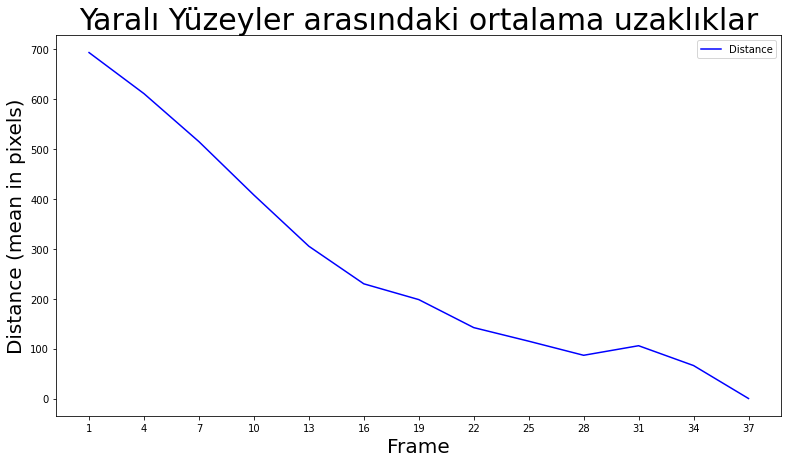

In [ ]:
f, ax = plt.subplots(figsize=(13, 7))
plt.plot(list(frames_dis.keys()), list(frames_dis.values()), label='Distance', color='b')
ax.set_ylabel('Distance (mean in pixels)', fontsize=20)
ax.set_xlabel('Frame', fontsize=20)
plt.title("Yaralı Yüzeyler arasındaki ortalama uzaklıklar", fontsize=30)
plt.legend()
plt.show()

In [ ]:
std_shwidth = []
for frame_dist in frame_distances:
    std_shwidth.append(np.std(np.array(list(frame_dist[1].values()))))

fig = go.Figure()
fig.add_trace(go.Bar(
    x=list(frames_dis.keys()),
    y=list(frames_dis.values()),
    marker_color='dodgerblue',
    error_y=dict(type='data', array=std_shwidth),
))

fig.update_layout(
    title_text='Standart Deviation of Scratch Width (px)',
    showlegend=False,
    yaxis=dict(
        title="Scratch Width (px)",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Frames",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        tickvals = list(frames_dis.keys()),
        ticks="outside",
        tickson="boundaries",
        ticklen=5
    ))
fig.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



In [ ]:
fig = go.Figure()
for frame in frame_distances:
    fig.add_trace(go.Box(
        y=list(frame[1].values()),
        name = frame[0] + ' .frame',
        marker_color='dodgerblue',
        boxpoints='all',
        boxmean='sd',
        jitter=0.5,
        whiskerwidth=0.9,
        marker_size=2,
        line_width=1
    ))

fig.update_layout(
    title_text='Scratch Width Analysis',
    showlegend=True,
    yaxis=dict(
        title="Scratch Width (px)",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Frames",
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ))
fig.show()



> **Her framede alınan her adım için uzaklık**



In [ ]:
fig = go.Figure(layout=go.Layout(
    xaxis=dict(title='Height (px)'),
    yaxis=dict(title='Distance (px)'),
    title='Yaralı Yüzeyin Uzaklıkları',
))
for frame in frame_distances:
    fig.add_trace(go.Scatter(x=list(frame[1].keys()),
                            y=list(frame[1].values()),
                            mode='markers+lines',
                            name=frame[0] + ". Frame"
                            ))

fig.show()



> **Animate Distances**



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


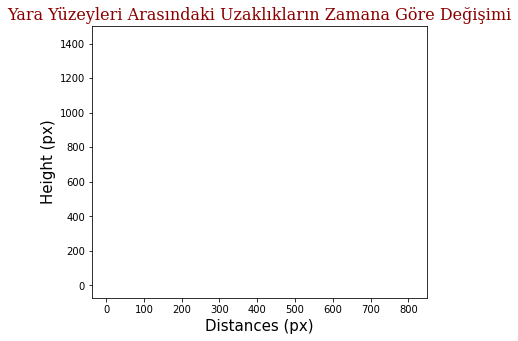

In [ ]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize=(6,5))
plt.title("Yara Yüzeyleri Arasındaki Uzaklıkların Zamana Göre Değişimi", fontdict=font)
plt.xlabel("Distances (px)", fontsize = 15)
plt.ylabel("Height (px)", fontsize = 15)
camera = Camera(fig)
    
for frame in frame_distances:   
    plt.plot(list(frame[1].values()), list(frame[1].keys()))
    plt.legend(loc = "upper left", title = frame[0] + " .Frame")
    camera.snap()
animation = camera.animate()
rc('animation', html='jshtml')
animation

In [ ]:
pio.templates.default = "ggplot2"

def get_layout(
    duration_long=1000 * 2,
    duration_short=800 * 2,
    ):
    updatemenus = [
        {
            'buttons': [
                {
                    'args': [
                        None,
                        {
                            'frame': {
                                'duration': duration_long,
                                'redraw': False,
                                },
                            'fromcurrent': True,
                            'transition': {
                                'duration': duration_short,
                                'easing': 'quadratic-in-out',
                                }
                            }
                        ],
                    'label': 'Play',
                    'method': 'animate'
                    },
                {
                    'args': [
                        [None],
                        {
                            'frame': {
                                'duration': 0,
                                'redraw': False,
                                },
                            'mode': 'immediate',
                            'transition': {'duration': 0},
                            }
                        ],
                    'label': 'Pause',
                    'method': 'animate'
                    }
                ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': True,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
            }
        ]
    layout = go.Layout(
        showlegend=False,
        title="Yara Yüzeyleri Arasındaki Uzaklıklar",
        xaxis={
            'autorange': True,
            'showgrid': True,
            'zeroline': True,
            'showline': True,
            'ticks': '',
            'showticklabels': True,
            'mirror': True,
            'linecolor': 'black',
            },

        yaxis={
            'autorange': True,
            'fixedrange': False,
            'showgrid': False,
            'zeroline': True,
            'showline': True,
            'ticks': '',
            'showticklabels': True,
            'mirror': True,
            'linecolor': 'black',
            },

        updatemenus=updatemenus,
        )

    return(layout)
 
def get_sliders_init_dict(duration_short):
    sliders_dict = {
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Frame #:',
            'visible': True,
            'xanchor': 'right'
            },
        'transition': {
            'duration': duration_short,  
            'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.8,
        'x': 0.1,
        'y': 0,
        'steps': [],
        }

    return(sliders_dict)

def get_slider_step_i(i_cnt, duration_short, name):
    slider_step_i = {
        'args': [
            [str(i_cnt)],
            {
                'frame': {
                    'duration': duration_short, 
                    'redraw': False},
                'mode': 'immediate',
                'transition': {
                    'duration': duration_short,
                    },
                },
            ],
        'label': name,
        'method': 'animate',
        }

    return(slider_step_i)

duration_long = 1000 * 3
duration_short = 800 * 3

def get_traces(xx,yy,i=0):
    colors = ["dodgerblue", "firebrick",
                "forestgreen", "fuchsia",
                "green","greenyellow", "indianred", "indigo",
                "darkgrey", "orange", "lightsteelblue", "mediumslateblue", "mediumspringgreen",
                "mediumturquoise", "mediumvioletred", "midnightblue",
                "mintcream", "mistyrose", "navajowhite", "navy",
                "oldlace", "olive", "olivedrab",
                "orchi","lavenderblush", "lawngreen"]
    trace = go.Scatter(
        x=xx,
        y=yy,
        mode="lines+markers",
        name="Frames",
        line=dict(color=colors[i]),
        )
    data = [trace]

    return (data)


layout_anim = get_layout(
    duration_long=duration_long,
    duration_short=duration_short)
sliders_dict = get_sliders_init_dict(duration_short)

frames = []; data = []

for frame in frame_distances:
    traces_i = get_traces(list(frame[1].values()),list(frame[1].keys()),frame_distances.index(frame))
    layout_i = go.Layout(

        )

    if frame_distances.index(frame) == 0: data.extend(traces_i)
    data_i = []; data_i.extend(traces_i)
    frame_i = go.Frame(data=data_i, name=str(frame_distances.index(frame)), layout=layout_i)
    frames.append(frame_i)
    slider_step_i = get_slider_step_i(frame_distances.index(frame), duration_short, frame[0])
    sliders_dict['steps'].append(slider_step_i)

fig = go.Figure(
    data=data,
    layout=layout_anim,
    frames=frames)
fig.update_layout(
    autosize=False,
    width=450,
    height=700,)
fig['layout']['sliders'] = [sliders_dict]
fig['layout']['xaxis'].update(title="Distances (px)", range=[0, 850], autorange=False)
fig['layout']['yaxis'].update(title="Height (px)", range=[0, 1600], autorange=False)
fig.show()



> **Metrics to quantify cell migration**


> ![alternatif metin](https://wikimedia.org/api/rest_v1/media/math/render/svg/2effed76a9349a788023cfd3a09706c221489f3b)

> Rm = Rate of cell migration

> Wi = Initial wound width

> Wf = Final wound width

> t = duration of migration



> Çizik testi, hücre göçünü incelemek için harika bir araçtır çünkü bu mekanizma birçok farklı fizyolojik açıdan rol oynar. Hücre göçü, cildin yeniden epitelizasyonunda büyük bir rol oynar ve bu nedenle hücre göçünün incelenmesi, iyileşmeyen yaraların anlaşılmasında ilerlemeler sağlayabilir. Hücre göçü, gastrulasyon ve organogenez gibi gelişimsel süreçlerde de temeldir. Hücre göçü ayrıca bağışıklık yanıtlarında ve kanser metastazlarında rol oynar. Aşağıda hücre göçünün hızı ölçülmüştür.

> **[Kaynak](https://www.jidonline.org/article/S0022-202X(16)32762-2/fulltext )**



In [ ]:
def cell_migrations(Wi, Wf, frame, hour=1):
    """Hucre gocu hizini hesaplar ve geri dondurur.
    Args:
        Wi (int): Deneyin ilk karesindeki ortalama yara alani genisligi.
        Wf (int): Olcumun yapilacagi son ortalama yara alani genisligi.
        frame (str): Kare sayisi.
        hour (str): Karelerin ne siklikla kaydedildigi (geçen süre) saat cinsinden.
    Returns:
        RM (float): Hucre gocu hizi
    """
    t = frame*hour
    return (Wi - Wf)/t

In [ ]:
Wi = frames_dis['1']
Wf = frames_dis['37']
frame_num = 37
Rm = cell_migrations(Wi, Wf, frame_num)
print(Rm, 'px/hour')

18.72447447444473 px/hour




> **Açık Yara Alanının Hesaplanması**



In [ ]:
ts_area = dict()

for frame in path:
    mask = cv2.imread(frame, 0)
    scratch_area = np.sum(mask == 0)
    ts_area[frame.split("/")[-1].split(".")[0].split("_")[-1]] = scratch_area



> **Wound Area Plotting**



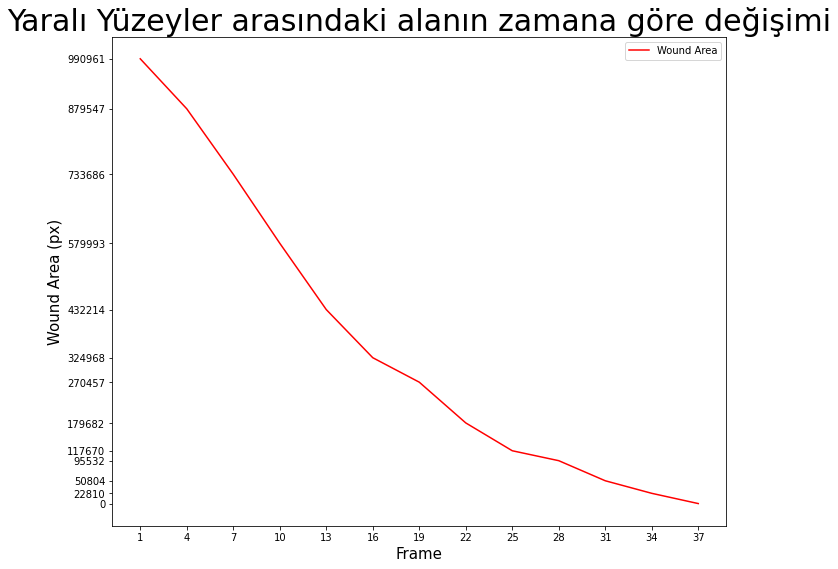

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))
plt.plot(list(ts_area.keys()), list(ts_area.values()), label='Wound Area', color='r')
plt.yticks(list(ts_area.values()))
ax.set_ylabel('Wound Area (px)', fontsize=15)
ax.set_xlabel('Frame', fontsize=15)
plt.title("Yaralı Yüzeyler arasındaki alanın zamana göre değişimi", fontsize=30)
plt.legend()
plt.show()



> **Çıkan eğrinin eğimi ve matematiksel gösterimi**

Veride bağımsız değişkenlerin, bağımlı değişkeni ne kadar açıkladığı R^2
ile açıklanır.




In [ ]:
from scipy.stats import linregress

times = [int(i) for i in list(ts_area.keys())] 
slope, intercept, r_value, p_value, std_err = linregress(times, list(ts_area.values()))
print("y = ",slope, "x", " + ", intercept  )
print("R\N{SUPERSCRIPT TWO} = ", r_value**2)

y =  -27818.1978021978 x  +  888416.8351648352
R² =  0.9248149955266532




> **Velocity**

> |slope| / 2*length

> slope: yaralı alanın eğrisi üzerinden çıkan eğim

> length: pixel cinsinden image uzunluğu

[**Kaynak**](https://www.sciencedirect.com/science/article/abs/pii/S0169260719313914)



In [ ]:
velocity = abs(slope)/(2*w)
velocity

7.2443223443223435



> **Yara Alanının Her Frameden Sonra Ne Kadar Kapanıyor**



In [ ]:
frames = [key for key in ts_area.keys()]
wound_a = [value for value in ts_area.values()]

variation = list()

for i in range(len(wound_a)-1):
    variation.append(wound_a[i] - wound_a[i+1])

to_frames = list()

for j in range(len(frames)-1):
    to_frames.append(frames[j] + " to -> " + frames[j+1])

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.001)
fig.append_trace(go.Bar(
    x=variation,
    y=to_frames,
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Yara Alanının Bir Sonraki Karede Azalma Miktarı',
    orientation='h',
), 1, 1)

fig.append_trace(go.Scatter(
    x=list(ts_area.values()), y=list(ts_area.keys()),
    mode='lines+markers',
    line_color='rgb(128, 0, 128)',
    name='Her Frame için Toplam Yara Alanı',
), 1, 2)

fig.update_layout(
    title='Yara Alanının Bir Sonraki Karede Azalma Miktarı',
    yaxis=dict(
        title="Frames",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    yaxis2=dict(
        title="Frames",
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
    ),
    xaxis=dict(
        title="Yara Alanında Azalma Miktarı (px)",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
    ),
    xaxis2=dict(
        title="Zamana Göre Yara Alanı (px)",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        side='top',
    ),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

fig.show()



> **Açık Yara Alanının Yüzdesel Oranı**



In [ ]:
percentage = dict()

for frame in path:
    mask = cv2.imread(frame, 0)
    percentage[frame.split("/")[-1].split(".")[0].split("_")[-1]] = ((mask[mask == 0].size) / (mask.size))*100

percentage

{'1': 35.842050057870374,
 '10': 20.97775607638889,
 '13': 15.632740162037036,
 '16': 11.753761574074074,
 '19': 9.782154224537038,
 '22': 6.498914930555555,
 '25': 4.256004050925926,
 '28': 3.4552951388888893,
 '31': 1.8375289351851853,
 '34': 0.8250144675925926,
 '37': 0.0,
 '4': 31.812319155092595,
 '7': 26.53667534722222}



> **Yara Alanı Bir Sonraki Karede Yüzdesel Olarak Azalma Miktarı**



In [ ]:
per_var = [(i/ts_area['1'])*100 for i in variation]

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.001)
fig.append_trace(go.Bar(
    x=per_var,
    y=to_frames,
    marker=dict(
        color='rgb(158, 202, 225, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Yara Alanının Bir Sonraki Karede Azalma Miktarı',
    orientation='h',
), 1, 1)

fig.append_trace(go.Scatter(
    x=list(percentage.values()), y=list(ts_area.keys()),
    mode='lines+markers',
    line_color='rgb(128, 0, 128)',
    name='Her Frame için Toplam Yara Alanı',
), 1, 2)

fig.update_layout(
    title='Yara Alanının Bir Sonraki Karede Azalma Miktarı',
    yaxis=dict(
        title="Frames",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    yaxis2=dict(
        title="Frames",
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
    ),
    xaxis=dict(
        title="Yara Alanında Azalma Miktarı (%)",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
    ),
    xaxis2=dict(
        title="Zamana Göre Yara Alanı (%)",
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        side='top',
    ),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

fig.show()



> **Wound Area Percentage Plotting**



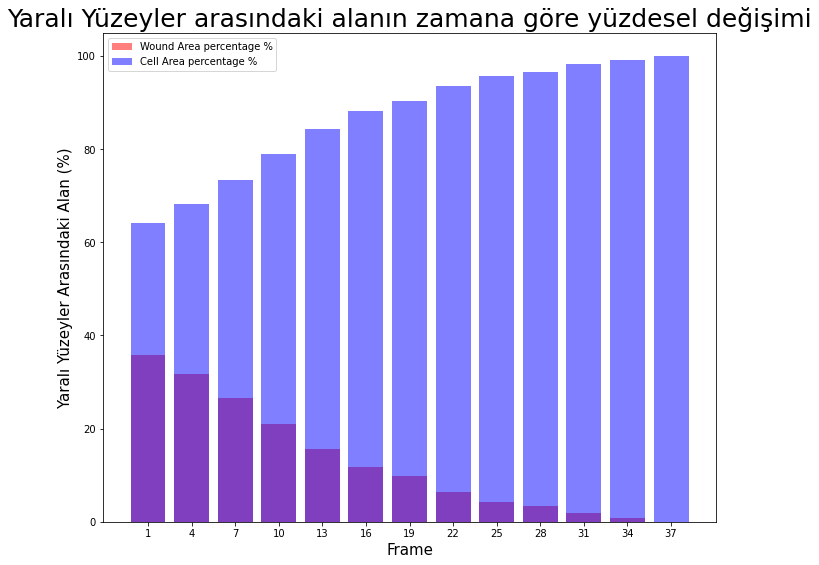

In [ ]:
cell_value = np.array(list(percentage.values()))
cell_value = 100 - cell_value
f, ax = plt.subplots(figsize=(11, 9))
rects1 = plt.bar(list(percentage.keys()), list(percentage.values()), label='Wound Area percentage %', color='r', alpha=0.5)
rects2 = plt.bar(list(percentage.keys()), cell_value, label='Cell Area percentage %', color='b', alpha=0.5)
ax.set_ylabel('Yaralı Yüzeyler Arasındaki Alan (%)', fontsize=15)
ax.set_xlabel('Frame', fontsize=15)
plt.title("Yaralı Yüzeyler arasındaki alanın zamana göre yüzdesel değişimi", fontsize=25)
plt.legend()
plt.show()



> **Hücre Yoğunluğu**



In [ ]:
cell_density = dict()

for frame in path:
    mask = cv2.imread(frame, 0)
    cell_density[frame.split("/")[-1].split(".")[0].split("_")[-1]] =  np.sum(mask == 255)

cell_density

{'1': 1773839,
 '10': 2184807,
 '13': 2332586,
 '16': 2439832,
 '19': 2494343,
 '22': 2585118,
 '25': 2647130,
 '28': 2669268,
 '31': 2713996,
 '34': 2741990,
 '37': 2764800,
 '4': 1885253,
 '7': 2031114}

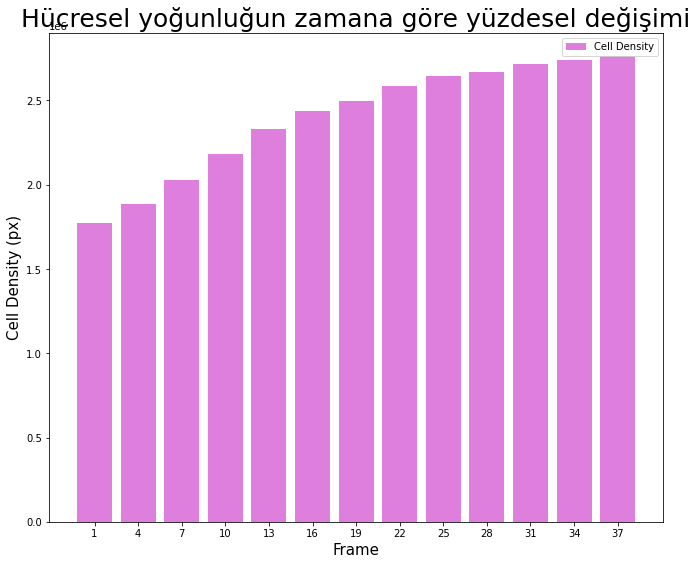

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))
plt.bar(list(cell_density.keys()), list(cell_density.values()), label='Cell Density', color='m', alpha=0.5)
ax.set_ylabel('Cell Density (px)', fontsize=15)
ax.set_xlabel('Frame', fontsize=15)
plt.title("Hücresel yoğunluğun zamana göre yüzdesel değişimi", fontsize=25)
plt.legend()
plt.show()



> **Bağıl Yara Yoğunluğu**



![alternatif metin](https://wikimedia.org/api/rest_v1/media/math/render/svg/a8a2a74df892bd2f71108118a3159fead378cdb2)


wt = t anında yara alanının yoğunluğu (İstenen)

ct = t anında hücresel alanın yoğunluğu (Referans)

Seçilen yoğunluğun belirli bir referans yoğunluğuna karşı bulunan yüzdesidir.




> [**Kaynak**](https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-015-0182-y)




In [ ]:
RWD = dict()

for key in ts_area.keys():
    RWD[key] = abs(((ts_area[key] - ts_area['1']) / (cell_density[key] - ts_area['1'])) * 100)

RWD

{'1': 0.0,
 '10': 34.42387041544722,
 '13': 41.64703251653778,
 '16': 45.966342069100705,
 '19': 47.925543873745994,
 '22': 50.89078428285294,
 '25': 52.72958254864088,
 '28': 53.35311120075171,
 '31': 54.56401059757927,
 '34': 55.290403528439555,
 '37': 55.86532937882187,
 '4': 12.458346938136538,
 '7': 24.734341966999086}

In [ ]:
fig = go.Figure(layout=go.Layout(
    xaxis=dict(title='Frames'),
    yaxis=dict(title='Relative Wound Density %'),
    title='Bağıl Yara Yoğunluğunun Zamana Göre Değişimi',
))

fig.add_trace(go.Scatter(
    x=list(RWD.keys()), y=list(RWD.values()),
    mode='lines+markers',
    line_color='rgb(128, 0, 128)',
    name='%RWD',
))
fig.update_layout(
    showlegend=True,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        tickvals = list(RWD.keys()),
        ticks="outside",
        tickson="boundaries",
        ticklen=5
    ),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    width=550,
    height=600,
)
fig.show()



> **Coordinate Bulma**



In [ ]:
step = 1
coordinate = dict()

for frame in path:
    left_coordinate = []
    right_coordinate = []
    mask = cv2.imread(frame, 0)
    height, width = mask.shape[:2]

    for h in range(0, height, step):
        boolarr = mask[h] == 0
        dist = np.array(np.where(boolarr))
        if dist.shape != (1,0):
            left_coordinate.append([dist[0].min(),h])
            right_coordinate.append([dist[0].max(),h])
    left_side = np.array(left_coordinate)
    right_side = np.array(right_coordinate)
    
    coordinate[frame.split("/")[-1].split(".")[0].split("_")[-1]] = [left_side, right_side]

#coordinate



> **Eğrilik (Curvature) Hesabı**


---







> Bir vektör değerli fonksiyonun temsil ettiği eğrinin yön değiştirme hızına ait ölçüme eğrilik denir. Bir eğri ne kadar eğrildiğinin ölçülmesidir.



<figure>
<center>
<img src="https://fastly.kastatic.org/ka-perseus-images/772874c6a2bfd02fbcd4c88e1f2e50c22117d120.svg"   width="300" height="200"/>
<figcaption>Curvature</figcaption></center>
</figure>
Eğri üzerinde bir noktadaki eğrilik yarıçapı, biçimsel olmayan şekilde ifade edersek, eğriye o noktada uyan çemberin yarıçapıdır. Linkte belirtildiği üzere
her noktayla ilişkili çemberin yarıçapını, bu noktadaki eğrilik yarıçapı olarak adlandırırız. Bu, verilen bir noktada bir eğrinin ne kadar eğrildiğini ölçmenin iyi bir yoludur. Bu çemberleri düşünmenin bir diğer yolu, o noktada eğriyle başka herhangi bir çemberden daha iyi eşleşmesidir. Yani bir eğri bir düz çizgi olmaya çok yakın olduğunda, eğrilik çok küçük olacaktır.

[Changing radius of convergence](https://youtu.be/GzwMwFrALzA)

Kısaca buradaki mantık, birim teğet vektörün size hangi yönde hareket ettiğinizi söylemesi ve bunun eğri boyunca ds küçük adımlarına göre değiştiği oranın, ne kadar hızlı döndüğünüzün iyi bir göstergesi olmasıdır.

<figure>
<center>
<img src="https://i.stack.imgur.com/Xby4N.png"/>
<figcaption>Curvature Formula</figcaption></center>
</figure>


> **[Kaynak](https://en.wikipedia.org/wiki/Curvature)**



In [ ]:
def cal_curvature(x, y):
    """Egrilik hesabi yapar.
    Args:
        x (numpy.array): Olcumun yapilacagi noktaların x bilesenleri.
        y (numpy.array): Olcumun yapilacagi noktaların y bilesenleri.
    Returns:
        curvature (numpy.array): Noktasal egrilik parametrelerinin bulundugu matris.
    """
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)

    ds_dt = np.sqrt((dx_dt ** 2) + (dy_dt ** 2))
    
    d2s_dt2 = np.gradient(ds_dt)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / ((dx_dt * dx_dt + dy_dt * dy_dt)**1.5)

    return curvature



> **Plotting Curvature**



In [ ]:
fig = go.Figure(layout=go.Layout(
    xaxis=dict(title='Noktaların Sayısı'),
    yaxis=dict(title='Noktasal Eğrilik (K)'),
    title='Eğrilik Analizi (Curvature Analysis)',
))
fig.add_trace(go.Scatter(y=cal_curvature(coordinate['1'][0][:,0], coordinate['1'][0][:,1]),
                        mode='lines',
                        name="1. Frame Sol Yara Yüzeyi"
                        ))
fig.add_trace(go.Scatter(y=cal_curvature(coordinate['1'][1][:,0], coordinate['1'][1][:,1]),
                        mode='lines',
                        name="1. Frame Sağ Yara Yüzeyi"
                        ))
fig.show()

In [ ]:
fig = go.Figure(layout=go.Layout(
    xaxis=dict(title='Noktaların Sayısı'),
    yaxis=dict(title='Noktasal Eğrilik (K)'),
    title='Eğrilik Analizi (Curvature Analysis)',
))
for key in coordinate.keys():
    if key != '37':
        fig.add_trace(go.Scatter(y=cal_curvature(coordinate[key][0][:,0], coordinate[key][0][:,1]),
                                mode='lines',
                                name=key + ". Frame Sol Yara Yüzeyi"
                                ))
        
        fig.add_trace(go.Scatter(y=cal_curvature(coordinate[key][1][:,0], coordinate[key][1][:,1]),
                                mode='lines',
                                name=key + ". Frame Sağ Yara Yüzeyi"
                                ))
fig.show()

In [ ]:
max_curv_left = list()
max_curv_right = list()

for key in coordinate.keys():
    if '37' not in key:
        max_curv_left.append(cal_curvature(coordinate[key][0][:,0], coordinate[key][0][:,1]).max())
        max_curv_right.append(cal_curvature(coordinate[key][1][:,0], coordinate[key][1][:,1]).max())

max_curv_left = np.array(max_curv_left)
max_curv_right = np.array(max_curv_right)



> **Animate Curvature**



In [ ]:
def get_layout(duration_long=1000 * 2, duration_short=800 * 2,):
    updatemenus = [
        {
            'buttons': [
                {
                    'args': [
                        None,
                        {
                            'frame': {
                                'duration': duration_long,
                                'redraw': False,
                                },
                            'fromcurrent': True,
                            'transition': {
                                'duration': duration_short,
                                'easing': 'quadratic-in-out',
                                }
                            }
                        ],
                    'label': 'Play',
                    'method': 'animate'
                    },
                {
                    'args': [
                        [None],
                        {
                            'frame': {
                                'duration': 0,
                                'redraw': False,
                                },
                            'mode': 'immediate',
                            'transition': {'duration': 0},
                            }
                        ],
                    'label': 'Pause',
                    'method': 'animate'
                    }
                ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': True,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
            }
        ]
    layout = go.Layout(
        showlegend=False,
        xaxis={
            'title': 'Noktalar',
            'autorange': True,
            'showgrid': True,
            'zeroline': True,
            'showline': True,
            'ticks': '',
            'showticklabels': True,
            'mirror': True,
            'linecolor': 'black',
            },

        yaxis={
            'title': 'Noktasal Eğrilik (K)',
            'autorange': True,
            'fixedrange': False,
            'showgrid': False,
            'zeroline': True,
            'showline': True,
            'ticks': '',
            'showticklabels': True,
            'mirror': True,
            'linecolor': 'black',
            },

        updatemenus=updatemenus,
        )

    return(layout)
 
def get_sliders_init_dict(duration_short):
    sliders_dict = {
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Frame #:',
            'visible': True,
            'xanchor': 'right'
            },
        'transition': {
            'duration': duration_short,  
            'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.8,
        'x': 0.1,
        'y': 0,
        'steps': [],
        }

    return(sliders_dict)

def get_slider_step_i(i_cnt, duration_short, name):
    slider_step_i = {
        'args': [
            [str(i_cnt)],
            {
                'frame': {
                    'duration': duration_short, 
                    'redraw': False},
                'mode': 'immediate',
                'transition': {
                    'duration': duration_short,
                    },
                },
            ],
        'label': name,
        'method': 'animate',
        }

    return(slider_step_i)

duration_long = 1000 * 3
duration_short = 800 * 3

def get_traces(yy):
    trace = go.Scatter(
        y=yy,
        mode="lines",
        )
    data = [trace]

    return (data)


layout_anim = get_layout(
    duration_long=duration_long,
    duration_short=duration_short)
sliders_dict = get_sliders_init_dict(duration_short)

frames = []; data = []

for key in l:
    traces_i = get_traces(cal_curvature(coordinate[key][0][:,0], coordinate[key][0][:,1]))
    layout_i = go.Layout(
            annotations=[
            go.layout.Annotation(
                x=1200,
                y=15,
                xref="x",
                yref="y",
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="#ffffff"
                    ),
                align="center",
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="#636363",
                ax=20,
                ay=-30,
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=0.8,
                text="Max Curvature: " + str(max_curv_left.max()),
                showarrow=False
                )
            ],
        )

    if l.index(key) == 0: data.extend(traces_i)
    data_i = []; data_i.extend(traces_i)
    frame_i = go.Frame(data=data_i, name=str(l.index(key)), layout=layout_i)
    frames.append(frame_i)
    slider_step_i = get_slider_step_i(l.index(key), duration_short, key)
    sliders_dict['steps'].append(slider_step_i)

layout_anim["title"] = "Eğrilik Analizi / Sol Yara Yüzeyi"

fig = go.Figure(
    data=data,
    layout=layout_anim,
    frames=frames)

fig['layout']['sliders'] = [sliders_dict]

fig.show()

In [ ]:
layout_anim = get_layout(
    duration_long=duration_long,
    duration_short=duration_short)
sliders_dict = get_sliders_init_dict(duration_short)

frames = []; data = []

for key in l:
    traces_i = get_traces(cal_curvature(coordinate[key][1][:,0], coordinate[key][1][:,1]))
    layout_i = go.Layout(
            annotations=[
            go.layout.Annotation(
                x=1200,
                y=12,
                xref="x",
                yref="y",
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="#ffffff"
                    ),
                align="center",
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="#636363",
                ax=20,
                ay=-30,
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=0.8,
                text="Max Curvature: " + str(max_curv_right.max()),
                showarrow=False
                )
            ],
        )

    if l.index(key) == 0: data.extend(traces_i)
    data_i = []; data_i.extend(traces_i)
    frame_i = go.Frame(data=data_i, name=str(l.index(key)), layout=layout_i)
    frames.append(frame_i)
    slider_step_i = get_slider_step_i(l.index(key), duration_short, key)
    sliders_dict['steps'].append(slider_step_i)

layout_anim["title"] = "Eğrilik Analizi / Sağ Yara Yüzeyi"

fig = go.Figure(
    data=data,
    layout=layout_anim,
    frames=frames)

fig['layout']['sliders'] = [sliders_dict]

fig.show()



> **Mean and Median Curvature**



In [ ]:
left_curvmean = list()
left_curvmedian = list()
left_curvstd_dev = list()

right_curvmean = list()
right_curvmedian = list()
right_curvstd_dev = list()

for key in coordinate.keys():
    if '37' not in key:
        left_curvature = cal_curvature(coordinate[key][0][:,0], coordinate[key][0][:,1])
        right_curvature = cal_curvature(coordinate[key][1][:,0], coordinate[key][1][:,1])

        left_curvmedian.append(np.median(left_curvature))
        left_curvmean.append(left_curvature.mean())
        left_curvstd_dev.append(np.std(left_curvature/left_curvature.max()))
        right_curvmedian.append(np.median(right_curvature))
        right_curvmean.append(right_curvature.mean())
        right_curvstd_dev.append(np.std(right_curvature/right_curvature.max()))
l = [key for key in coordinate.keys()]
del l[-1]

In [ ]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Bar(
    x=l,
    y=left_curvmedian,
    name='LEFT-MEDIAN',
    marker_color='indianred',
),1, 1)
fig.add_trace(go.Bar(
    x=l,
    y=left_curvmean,
    name='LEFT-MEAN',
    error_y=dict(type='data', array=left_curvstd_dev),
    marker_color='lightsalmon'
),1, 1)

fig.update_layout(barmode='group',title='Mean and Median Curvature Analysis',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Mean and Median in Curvature Matrix',
        titlefont_size=16,
        tickfont_size=14,
    ),
    xaxis=dict(
        title='Frames',
        titlefont_size=16,
        tickfont_size=14,
    ),
    yaxis2=dict(
        titlefont_size=16,
        tickfont_size=14,
    ),
    xaxis2=dict(
        title='Frames',
        titlefont_size=16,
        tickfont_size=14,
    )
   )

fig.add_trace(go.Bar(
    x=l,
    y=right_curvmedian,
    name='RIGHT-MEDIAN',
    marker_color='lightskyblue',
),1, 2)
fig.add_trace(go.Bar(
    x=l,
    y=right_curvmean,
    name='RIGHT-MEAN',
    marker_color='limegreen',
    error_y=dict(type='data', array=right_curvstd_dev),
),1, 2)

fig.update_layout(barmode='group',
    xaxis=dict(
        title='Frames',
        titlefont_size=16,
        tickfont_size=14,
    ))
fig.show()

In [ ]:
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, 30)]

fig = make_subplots(rows=1, cols=2, shared_yaxes=True)

for key in coordinate.keys():
    if key != '37':
        fig.add_trace(go.Box(
            y=cal_curvature(coordinate[key][0][:,0], coordinate[key][0][:,1]),
            name=key + ". Frame-Left",
            boxmean='sd',
            boxpoints=False,
            marker_color=c[l.index(key)]
        ),1, 1)

        fig.add_trace(go.Box(
            y=cal_curvature(coordinate[key][1][:,0], coordinate[key][1][:,1]),
            name=key + ". Frame-Right",
            boxmean='sd',
            boxpoints=False,
            marker_color=c[l.index(key)]
        ),1, 2)

fig.update_layout(
    title='Curvature Analysis Mean Median and Std Deviation',
    yaxis=dict(
        title="Curvature (K)",
        autorange=False,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
    ),
    xaxis=dict(
        title="Frames",
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True,
    boxmode="group",
)


fig.show()

In [ ]:
fig = go.Figure()

for key in l:
        fig.add_trace(go.Box(
            y=cal_curvature(coordinate[key][0][:,0], coordinate[key][0][:,1]),
            name=key,
            boxpoints='all',
            boxmean='sd',
            jitter=0.5,
            whiskerwidth=0.9,
            marker_size=2,
            line_width=1)
        )

fig.update_layout(
    title='Sol Yüzey Eğrilik Analizi',
    yaxis=dict(
        title="Eğrilik (K)",
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    xaxis=dict(
        title="Frames",
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)

fig.show()

In [ ]:
fig = go.Figure()

for key in l:
        fig.add_trace(go.Box(
            y=cal_curvature(coordinate[key][1][:,0], coordinate[key][1][:,1]),
            name=key,
            boxpoints='all',
            boxmean='sd',
            jitter=0.5,
            whiskerwidth=0.9,
            marker_size=2,
            line_width=1)
        )

fig.update_layout(
    title='Sağ Yüzey Eğrilik Analizi',
    yaxis=dict(
        title="Eğrilik (K)",
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    xaxis=dict(
        title="Frames",
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)

fig.show()



> **İki farklı deney gibi iki farklı işaretleme için cell migration RWD ve cell_density karşılaştırılması**


---





In [ ]:
path_cat = glob.glob('/content/masks_2/*.png')
path_cat.sort(key=natural_keys)
print(path_cat)

['/content/masks_2/out1.png', '/content/masks_2/out4.png', '/content/masks_2/out7.png', '/content/masks_2/out10.png', '/content/masks_2/out13.png', '/content/masks_2/out16.png', '/content/masks_2/out19.png', '/content/masks_2/out22.png', '/content/masks_2/out25.png', '/content/masks_2/out28.png', '/content/masks_2/out31.png', '/content/masks_2/out34.png', '/content/masks_2/out37.png']


In [ ]:
cell_density_cat = dict()

for frame in path_cat:
    mask = cv2.imread(frame, 0)
    cell_density_cat[frame.split("/")[-1].split(".")[0].split("_")[-1]] =  np.sum(mask == 255)

cell_density_cat

{'out1': 1772546,
 'out10': 2215549,
 'out13': 2340184,
 'out16': 2424863,
 'out19': 2473031,
 'out22': 2543162,
 'out25': 2591988,
 'out28': 2629075,
 'out31': 2685388,
 'out34': 2733122,
 'out37': 2764800,
 'out4': 1906288,
 'out7': 2054990}

In [ ]:
frame_distances1 = []
step = 10

for frame in path_cat:
    mask = cv2.imread(frame, 0)
    height, width = img.shape[:2]
    distances = dict()

    for h in range(0, height, step):
        boolarr = mask[h] == 0
        dist = np.array(np.where(boolarr))
        if dist.shape != (1,0):
            distances[h] = dist[0].max() - dist[0].min()

    frame_distances1.append([frame.split("/")[-1].split(".")[0].split("_")[-1], distances])

frames_dis1 = dict()

for frame_dist in frame_distances1:
    data = frame_dist[1].values()
    frame = frame_dist[0]
    data = np.array(list(data))
    frames_dis1[frame] = 0 if np.isnan(data.mean()) else data.mean() 

frames_dis1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



{'out1': 690.0625,
 'out10': 388.11805555555554,
 'out13': 996.7430555555555,
 'out16': 247.36805555555554,
 'out19': 216.42361111111111,
 'out22': 179.41843971631207,
 'out25': 161.1782945736434,
 'out28': 124.64462809917356,
 'out31': 113.1038961038961,
 'out34': 75.38636363636364,
 'out37': 0,
 'out4': 596.5347222222222,
 'out7': 497.7638888888889}



> **Hücresel Yoğunluk Karşılaştırması**



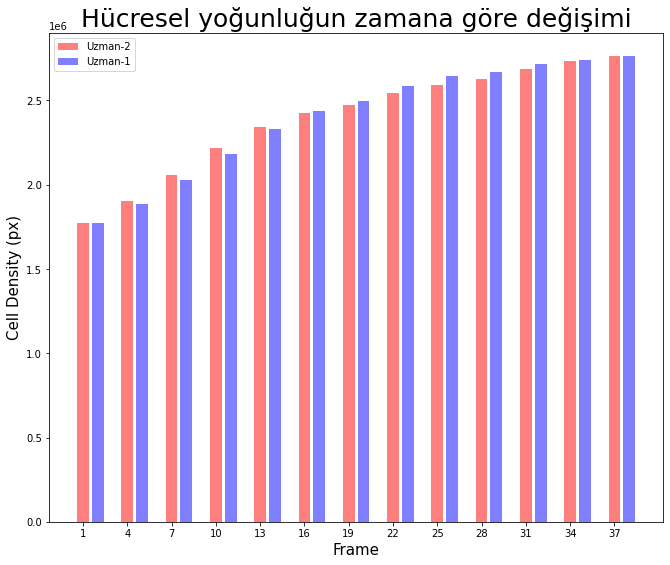

In [ ]:
frames = np.array([int(i) for i in list(cell_density.keys())]) 
f, ax = plt.subplots(figsize=(11, 9))
rects1 = plt.bar(frames, list(cell_density_cat.values()), label='Uzman-2', color='r', alpha=0.5, align='center')
rects2 = plt.bar(frames+1, list(cell_density.values()), label='Uzman-1', color='b', alpha=0.5, align='center')
plt.xticks(frames)
ax.set_ylabel('Cell Density (px)', fontsize=15)
ax.set_xlabel('Frame', fontsize=15)
plt.title("Hücresel yoğunluğun zamana göre değişimi", fontsize=25)
plt.legend()
plt.show()





> **Hücresel Göç Karşılaştırılması**



In [ ]:
Wi = frames_dis['1']
Wf = frames_dis['37']
frame_num = 37

Wi1 = frames_dis1['out1']
Wf1 = frames_dis1['out37']
frame_num1 = 37

no_cat = cell_migrations(Wi1, Wf1, frame_num1)
catalizor = cell_migrations(Wi, Wf, frame_num)

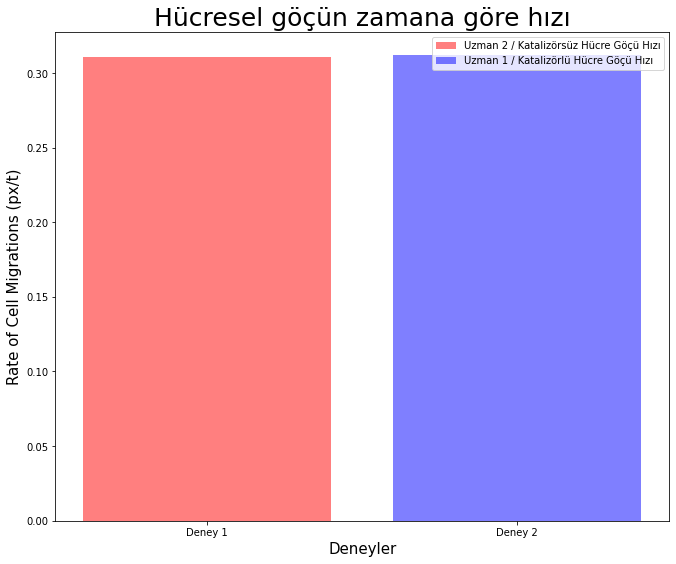

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))
rects1 = plt.bar('Deney 1', no_cat, label='Uzman 2 / Katalizörsüz Hücre Göçü Hızı', color='r', alpha=0.5, align='center')
rects2 = plt.bar('Deney 2', catalizor, label='Uzman 1 / Katalizörlü Hücre Göçü Hızı', color='b', alpha=0.5, align='center')
ax.set_ylabel('Rate of Cell Migrations (px/t)', fontsize=15)
ax.set_xlabel('Deneyler', fontsize=15)
plt.title("Hücresel göçün zamana göre hızı", fontsize=25)
plt.legend()
plt.show()


> **Konum Analizi**



In [ ]:
first_location = coordinate['1'][0][64]
result = np.where(coordinate['34'][0] == 64)
last_location = coordinate['34'][0][result[0]]

In [ ]:
first_location1 = coordinate['1'][1][64]
result = np.where(coordinate['34'][1] == 64)
last_location1 = coordinate['34'][1][result[0]]

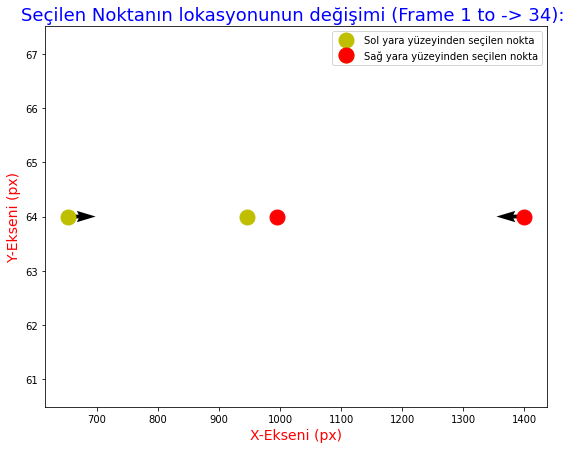

In [ ]:
f, ax = plt.subplots(figsize=(9, 7))
plt.title('Seçilen Noktanın lokasyonunun değişimi (Frame 1 to -> 34): ', fontsize=18, color='blue')
plt.ylabel('Y-Ekseni (px)', fontsize=14, color='red')
plt.xlabel('X-Ekseni (px)', fontsize=14, color='red')
red_dot, = plt.plot(first_location[0], first_location[1], 'yo', markersize=15)
plt.quiver(first_location[0], first_location[1], 1,0)
red_dot1, = plt.plot(last_location[0][0], last_location[0][1], 'yo', markersize=15)
white_cross, = plt.plot(first_location1[0], first_location1[1], 'ro', markersize=15)
plt.quiver(first_location1[0], first_location1[1], -1,0)
white_cross1, = plt.plot(last_location1[0][0], last_location1[0][1], 'ro', markersize=15)
plt.legend([red_dot, (red_dot, white_cross)], ["Sol yara yüzeyinden seçilen nokta", "Sağ yara yüzeyinden seçilen nokta"])



> **Birden Fazla Nokta Seçilerek Konum Analizi**



In [ ]:
first_location_left = list()
last_location_left = list()

h,_= coordinate['1'][0].shape[:2]
step = 64

for i in range(0, h//2, step):
    first_location_left.append(coordinate['1'][0][i])
    result = np.where(coordinate['34'][0] == i)
    last_location_left.append(coordinate['34'][0][result[0]])

In [ ]:
first_location_right = list()
last_location_right = list()

h,_= coordinate['1'][0].shape[:2]
step = 64

for i in range(0, h//2, step):
    first_location_right.append(coordinate['1'][1][i])
    result = np.where(coordinate['34'][1] == i)
    last_location_right.append(coordinate['34'][1][result[0]])

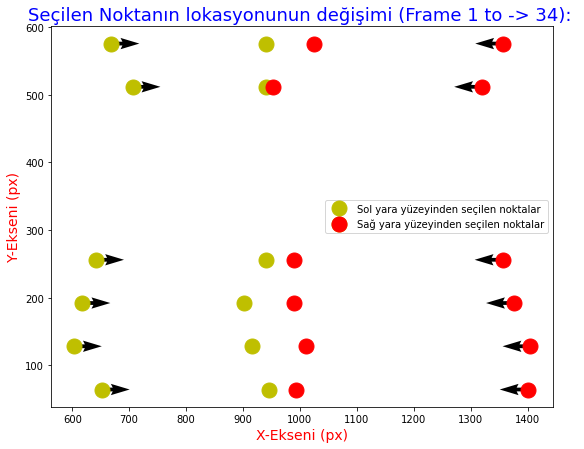

In [ ]:
f, ax = plt.subplots(figsize=(9, 7))
plt.title('Seçilen Noktanın lokasyonunun değişimi (Frame 1 to -> 34): ', fontsize=18, color='blue')
plt.ylabel('Y-Ekseni (px)', fontsize=14, color='red')
plt.xlabel('X-Ekseni (px)', fontsize=14, color='red')

for i, j in zip(first_location_left, last_location_left):
    if (i.size != 0) and (j.size != 0): 
        red_dot, = plt.plot(i[0], i[1], 'yo', markersize=15)
        plt.quiver(i[0], i[1], 1,0)
        red_dot1, = plt.plot(j[0][0], j[0][1], 'yo', markersize=15)

for k, l in zip(first_location_right, last_location_right):
    if (k.size != 0) and (l.size != 0): 
        white_cross, = plt.plot(k[0], k[1], 'ro', markersize=15)
        plt.quiver(k[0], k[1], -1,0)
        white_cross1, = plt.plot(l[0][0], l[0][1], 'ro', markersize=15)

plt.legend([red_dot, (red_dot, white_cross)], ["Sol yara yüzeyinden seçilen noktalar", "Sağ yara yüzeyinden seçilen noktalar"])



> **Yara Yüzeyleri Davranış Analizi**



In [ ]:
def cal_normal(x, y):
    """Verilen egri noktaları uzerinden o egrinin normal vektorlerini hesaplar.
    Args:
        x (numpy.array): Olcumun yapilacagi noktaların x bilesenleri.
        y (numpy.array): Olcumun yapilacagi noktaların y bilesenleri.
    Returns:
        normal (numpy.array): Normal vektorlerin bulundugu matris.
    """
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])
    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)
    tangent = np.array([1/ds_dt] * 2).transpose() * velocity

    derivative_tangent_x = np.gradient(tangent[:, 0])
    derivative_tangent_y = np.gradient(tangent[:, 1])

    dT_dt = np.array([ [derivative_tangent_x[i], derivative_tangent_y[i]] for i in range(derivative_tangent_x.size)])
    length_dT_dt = np.sqrt(derivative_tangent_x * derivative_tangent_x + derivative_tangent_y * derivative_tangent_y)
    normal = np.array([1/length_dT_dt] * 2).transpose() * dT_dt
    
    return normal

In [ ]:
normal_left = list()
normal_right = list()

for key in l:
    normal_left.append(cal_normal(coordinate[key][0][:,0], coordinate[key][0][:,1]))
    normal_right.append(cal_normal(coordinate[key][1][:,0], coordinate[key][1][:,1]))

In [ ]:
f, ax = plt.subplots(figsize=(10, 30))
plt.plot(coordinate['4'][0][:,0], coordinate['4'][0][:,1], label='sol yara yüzeyi', color='r')
plt.quiver(coordinate['4'][0][:,0], coordinate['4'][0][:,1], normal_left[3][:,0], normal_left[3][:,1], scale=35)
ax.set_ylabel('Y Ekseni (px)', fontsize=15)
ax.set_xlabel('X Ekseni (px)', fontsize=15)
plt.title("4. Frame Sol Yara Yüzeyi Normal Vektörleri", fontsize=20)
plt.legend()
plt.show()



> **Animate Normal Vector**



In [ ]:
xsr = coordinate['1'][1][:,0]
ysr = coordinate['1'][1][:,1]
xs = coordinate['1'][0][:,0]
ys = coordinate['1'][0][:,1]

In [ ]:
area_plot = [value for value in ts_area.values()]
area_plot = np.array(area_plot)
#plotting immidiatly area

In [ ]:
pio.templates.default = "simple_white"

fig = make_subplots(
    rows=1, cols=2, subplot_titles=('Normal Vector with Wound Surface', 'Wound Area'),
    horizontal_spacing=0.119
)

fig.add_trace( go.Scatter(x=xs, y=ys,
                     name="Sol Yara Yüzeyi",
                     mode="lines",
                     ))

fig.add_trace(go.Scatter(x=xsr, y=ysr,
                     name="Sağ Yara Yüzeyi",
                     mode="lines",
                     ))

fig.add_trace(go.Scatter(x=['1'], y=[ts_area['1']],
                     name="Açık Yara Alanı",
                     mode="lines+markers",
                     ), row=1, col=2)

frames =[go.Frame(data=[go.Scatter(x=coordinate[key][0][:,0], y=coordinate[key][0][:,1],
                        name="Sol Yara Yüzeyi",
                        mode="lines+markers",
                        visible=True,
                        ),
                        go.Scatter(x=coordinate[key][1][:,0], y=coordinate[key][1][:,1],
                        name="Sağ Yara Yüzeyi",
                        mode="lines+markers",
                        visible=True,
                        ),
                        go.Scatter(
                            name="Açık Yara Alanı",
                            x=l[:l.index(key)+1],
                            y=area_plot[:l.index(key)+1],
                            mode="markers+lines",
                            visible=True,
                            )],
                  traces=[0,1,2]) for key in l]  

fig.frames=frames
button = dict(
             label='Play',
             method='animate',
             args=[None, dict(frame=dict(duration=800 * 2, redraw=False), 
                              transition=dict(duration=0),
                              fromcurrent=True,
                              mode='immediate')])
fig.update_layout(updatemenus = [
        {
            'buttons': [
                {
                    'args': [
                        None,
                        {
                            'frame': {
                                'duration': duration_long,
                                'redraw': True,
                                },
                            'fromcurrent': True,
                            'transition': {
                                'duration': duration_short,
                                'easing': 'exp-in-out',
                                }
                            }
                        ],
                    'label': 'Play',
                    'method': 'animate'
                    },
                {
                    'args': [
                        [None],
                        {
                            'frame': {
                                'duration': 0,
                                'redraw': False,
                                },
                            'mode': 'immediate',
                            'transition': {'duration': 0},
                            }
                        ],
                    'label': 'Pause',
                    'method': 'animate'
                    }
                ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': True,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
            }
        ],
                 width=800, height=500)

fig.update_layout(yaxis2_range=[0, ts_area['1']+10000], yaxis2_autorange=False, yaxis2_title="Woud Area (px)")
fig.update_layout(xaxis2_range=[0, 45], yaxis2_autorange=False, xaxis2_title="Frames")
fig.update_layout(yaxis_title="Height (px)")
fig.update_layout(xaxis_title="Width (px)")        

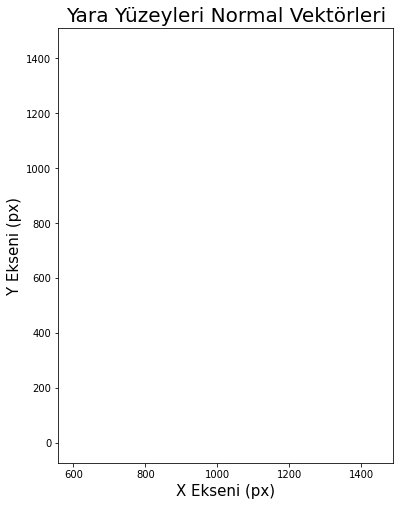

In [ ]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize=(6,8))

plt.ylabel('Y Ekseni (px)', fontsize=15)
plt.xlabel('X Ekseni (px)', fontsize=15)
plt.title("Yara Yüzeyleri Normal Vektörleri", fontsize=20)
plt.rcParams["figure.figsize"] = (15,10)
camera = Camera(fig)
    
for key in l:
    plt.plot(coordinate[key][0][:,0], coordinate[key][0][:,1],label='sol yara yüzeyi', color='r', )
    plt.plot(coordinate[key][1][:,0], coordinate[key][1][:,1],label='sağ yara yüzeyi', color='b', )   
    for k in range(0, len(normal_left[l.index(key)]), 50):
        plt.quiver(coordinate[key][0][:,0][k], coordinate[key][0][:,1][k], normal_left[l.index(key)][:,0][k], normal_left[l.index(key)][:,1][k], scale=15)
    for j in range(0, len(normal_right[l.index(key)]), 50):    
        plt.quiver(coordinate[key][1][:,0][j], coordinate[key][1][:,1][j], normal_left[l.index(key)][:,0][j], normal_left[l.index(key)][:,1][j], scale=15)    
    camera.snap()

animation = camera.animate()
rc('animation', html='jshtml')
animation


In [ ]:
#vector annotations

normal_vectors = dict()


for key in l:

    list_of_all_arrows = []

    for i in range(0, len(normal_left[l.index(key)]), 50):
        if (not np.isnan(normal_left[l.index(key)][:,0][i])) and (not np.isnan(normal_left[l.index(key)][:,1][i])):
            arrow = go.layout.Annotation(
                        x= coordinate[key][0][:,0][i],
                        y= coordinate[key][0][:,1][i],
                        xref="x", yref="y",
                        text="",
                        showarrow=True,
                        ax= normal_left[l.index(key)][:,0][i],
                        ay= normal_left[l.index(key)][:,1][i],
                        arrowhead = 2,
                        arrowwidth=1.5,
                        arrowcolor='black'
                    )
            list_of_all_arrows.append(arrow)

    for j in range(0, len(normal_right[l.index(key)]), 50):
        if (not np.isnan(normal_right[l.index(key)][:,0][j])) and (not np.isnan(normal_right[l.index(key)][:,1][j])):
            arrow = go.layout.Annotation(
                        x= coordinate[key][1][:,0][j],
                        y= coordinate[key][1][:,1][j],
                        xref="x", yref="y",
                        text="",
                        showarrow=True,
                        ax= normal_right[l.index(key)][:,0][j],
                        ay= normal_right[l.index(key)][:,1][j],
                        arrowhead = 2,
                        arrowwidth=1.5,
                        arrowcolor='black'
                    )
            list_of_all_arrows.append(arrow)

    normal_vectors[key] = list_of_all_arrows


"""
                  go.Scatter(
                            name="Açık Yara Alanı",
                            x=l[:l.index(key)+1],
                            y=area_plot[:l.index(key)+1],
                            mode="markers+lines",
                            visible=True,
                            )],
                  layout=go.Layout(annotations=normal_vectors[key],),
                  traces=[0,1,2]) for key in l]  
"""

# **Automatic Analysis Tool with U-net**



> **Importing Modules**



In [ ]:
import cv2
from skimage.io import imread, imshow
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from skimage.transform import rotate, resize
from skimage import data
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
import glob
import random
import re
from tqdm import tqdm
import tensorflow as tf
from google.colab.patches import cv2_imshow
import h5py

> **Random Train and Test Path**

In [ ]:
ground_th = glob.glob('/content/masks/*.png')
images = glob.glob('/content/frames/*.png')

In [ ]:
train_num = 10

In [ ]:
choices_gnd_train = random.sample(ground_th, train_num)
choices_img_train = []
for img in images:
    for gnd in choices_gnd_train:
        if  img.split("/")[-1] in gnd:
            choices_img_train.append(img)
            break

In [ ]:
choices_gnd_test = []
choices_img_test = []
for i, j in zip(ground_th, images):
    if (i not in choices_gnd_train) and (j not in choices_img_train):
        choices_gnd_test.append(i)
        choices_img_test.append(j)

In [ ]:
choices_gnd_test.sort(key=natural_keys)
choices_img_test.sort(key=natural_keys)
choices_img_train.sort(key=natural_keys)
choices_gnd_train.sort(key=natural_keys)


> **Resizing Training Images and Masks**

In [ ]:
#seed = 42
#np.random.seed = seed
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 256, 256, 3

X_train = np.zeros((len(choices_img_train)*2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(choices_img_train)*2, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Resizing training images and masks..')
n=0
for gnd, frame in tqdm(zip(choices_gnd_train, choices_img_train), total=len(choices_img_train)):   
    img = imread(frame)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img_rot = tf.image.rot90(img)
    X_train[n] = img  
    X_train[n+1] = img_rot
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(gnd)
    mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
    mask = np.expand_dims(mask_, axis=-1)
    mask /= 255
    mask = mask.astype(np.bool)
    mask_rot = tf.image.rot90(mask)     
    Y_train[n] = mask
    Y_train[n+1] = mask_rot

    n+=2
print('Done!')  

  0%|          | 0/10 [00:00<?, ?it/s]

Resizing training images and masks..


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

Done!



> **Resizing Test Images**

In [ ]:
X_test = np.zeros((len(choices_img_test), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
#print('Resizing test images..') 

for n, test in tqdm(enumerate(choices_img_test), total=len(choices_img_test)):
    img = imread(test)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Y_test = np.zeros((len(choices_gnd_test), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, test in tqdm(enumerate(choices_gnd_test), total=len(choices_gnd_test)):
    mask = imread(test)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = np.expand_dims(mask, axis=-1)
    mask /= 255
    mask = mask.astype(np.bool)
    Y_test[n] = mask

print('Done!')

 33%|███▎      | 1/3 [00:00<00:00,  9.51it/s]

Done!


100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

Done!



> **Control Resizing Images**

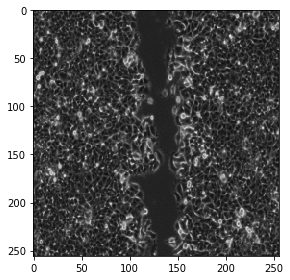

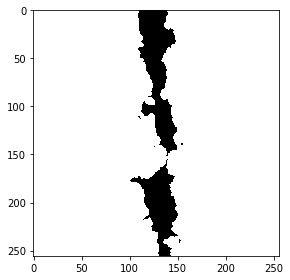

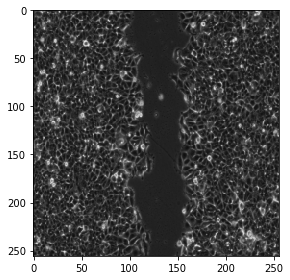

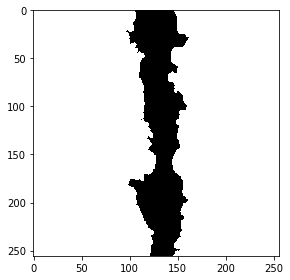

In [ ]:
image_x = random.randint(0, len(choices_img_train)-1)
image_xt = random.randint(0, len(choices_img_test)-1)
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()
imshow(np.squeeze(X_test[image_xt]))
plt.show()
imshow(np.squeeze(Y_test[image_xt]))
plt.show()


> **Metrics**

In [ ]:
from keras.losses import binary_crossentropy
import keras.backend as K


def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

    
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    jac = (intersection + 1.) / (union - intersection + 1.)
    return K.mean(jac)


def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y


def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss



> **Define U-net Model**

In [ ]:
def get_unet(input_shape=(256, 256, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)

    #model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coeff])

    return model



> **Train the Model**



In [ ]:
from sklearn.model_selection import KFold

acc_per_fold = []
loss_per_fold = []
iou_per_fold= []

num_epochs=120
num_folds = 10

kfold = KFold(n_splits=num_folds, shuffle=True)

model_filename = 'scratch_model.h5'

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='loss', 
    save_best_only=True,
)


fold_no = 1
for train, test in kfold.split(X_train, Y_train):
    model = get_unet()

    model.compile(
        optimizer=Adam(), 
        loss='binary_crossentropy',
        metrics=['accuracy', iou, iou_thresholded]
    )

    print('-'*50)
    print(f'Training for fold {fold_no} ... please wait..')

    history = model.fit(X_train[train], Y_train[train],
              batch_size=len(X_train[train]),
              epochs=num_epochs,
              callbacks=[callback_checkpoint],
              verbose = 1)
    
    model.save_weights('model_weights_{}_{}.h5'.format(IMG_WIDTH, num_epochs))

    scores = model.evaluate(X_train[test], Y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    iou_per_fold.append(scores[2])

    fold_no += 1



> **Show Loss and Metrics Measurement**



In [ ]:
plt.plot(history.history['dice_coeff'])
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();



> **Test the Model**



1/1 [==============================] - 0s 27ms/step


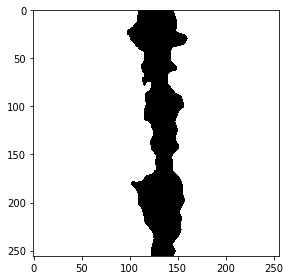

In [ ]:
preds_test = model.predict(X_test, verbose=1)
h = np.squeeze(preds_test[2])
h[h > .5] = 1
h[h < .5] = 0
imshow(h)

In [ ]:
res = np.squeeze(preds_test[2])
imshow(res)



> **Test the Contour**



In [ ]:
res = np.squeeze(preds_test[0])
res[res > .5] = 1
res[res < .5] = 0
img=cv2.imread(choices_img_test[0])
h,w=img.shape[:2]
res_ = resize(res, (h, w))
res_ = res_.astype('uint8')
res_ = res_*255 
contours, _ = cv2.findContours(res_, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
cv2_imshow(img)



> **Load Modal**



In [ ]:
model.load_weights('/content/model.hdf5')
print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
imgs_mask_test = model.predict(X_test, verbose=1)
np.save('imgs_mask_test.npy', imgs_mask_test)